# Classifiez automatiquement des biens de consommation

- **Projet 6 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Classification de textes


<!--TABLE OF CONTENTS-->

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
- [2. Import, nettoyage et analyse exploratoire des données](#2.-Import,-nettoyage-et-analyse-exploratoire-des-données)
  - [2.1 Import des données](#2.1-Import-des-données)
  - [2.2 Nettoyage des données](#2.2-Nettoyage-des-données)
  - [2.3 Analyse exploratoire](#2.3-Analyse-exploratoire)
  - [2.4 Elimination des colonnes non-pertinentes au problématique](#2.4-Elimination-des-colonnes-non-pertinentes-au-problématique)
- [3. Feature engineering / preprocessing](#3.-Feature-engineering-/-preprocessing)
  - [3.1 Préparation des catégories](#3.1-Préparation-des-catégories)
  - [3.2 Préparation (preprocessing) des déscriptions des données](<#3.2-Préparation-(preprocessing)-des-déscriptions-des-données>)
  - [3.3 Pipeline pour création des features 'sentence' pour les modeles](#3.3-Pipeline-pour-création-des-features-'sentence'-pour-les-modeles)
  - [3.4 Enregistre les données préparées](#3.4-Enregistre-les-données-préparées)
  - [3.5 Nettoyage des variables globales](#3.5-Nettoyage-des-variables-globales)
- [4. Fonctions communs pour modèles NLP](#4.-Fonctions-communs-pour-modèles-NLP)
  - [4.1 Lecture des données](#4.1-Lecture-des-données)
  - [4.2 Fonctions communes](#4.2-Fonctions-communes)
- [5. Bag-of-Words et TF-IDF](#5.-Bag-of-Words-et-TF-IDF)
  - [5.1 Essaie 1 : Bag of words (BOW)](<#5.1-Essaie-1-:-Bag-of-words-(BOW)>)
  - [5.2 Essaie 2 : TF-IDF](#5.2-Essaie-2-:-TF-IDF)
- [6. LDA - (Topic modelling)](<#6.-LDA---(Topic-modelling)>)
- [7. Word2Vec](#7.-Word2Vec)
  - [7.1 Essaie 4 : Word2Vec sur phrases lemmatizes](#7.1-Essaie-4-:-Word2Vec-sur-phrases-lemmatizes)
  - [Création de la matrice d'embedding](#Création-de-la-matrice-d'embedding)
  - [Création du modèle d'embedding](#Création-du-modèle-d'embedding)
  - [Exécution du modèle](#Exécution-du-modèle)
- [7. BERT](#7.-BERT)
  - [7.1 BERT - Fonctions communes](#7.1-BERT---Fonctions-communes)
  - [7.2 Essaie 5 : BERT HuggingFace](#7.2-Essaie-5-:-BERT-HuggingFace)
  - [7.3 Essaie 6 : BERT hub Tensorflow](#7.3-Essaie-6-:-BERT-hub-Tensorflow)
- [8. USE - Universal Sentence Encoder](#8.-USE---Universal-Sentence-Encoder)
  - [8. Essaie 7 : USE - Universal Sentence Encoder](#8.-Essaie-7-:-USE---Universal-Sentence-Encoder)
- [9. Enregistrement des résultats](#9.-Enregistrement-des-résultats)


# 1. Compréhension du problème

## 1.1 Mission

Etudier la faisabilité d'un **moteur de classification** des articles en différentes catégories,
avec un niveau de précision suffisant.

- **réaliser une première étude de faisabilité d'un moteur de classification**, d'articles, basé sur
  une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et
  des images, une **réduction de dimension**, puis un **clustering**, à présenter sous la forme de
  graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories
  réelles et les clusters.
- illustre que les caractéristiques extraites permettent de regrouper des produits de même
  catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des
  produits de même catégorie


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas',
                      'matplotlib', 'seaborn', 'scikit-learn',
                      'nltk==3.7',
                      'gensim==4.1.2',
                      'tensorflow==2.8.0',
                      'transformers',
                      'tensorflow_hub',
                      'tensorflow_text',
                      'wordcloud'}
install_libraries(required_libraries)


missing libraries: {'tensorflow==2.8.0', 'tensorflow_hub', 'nltk==3.7', 'gensim==4.1.2', 'tensorflow_text'}


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import gensim
import tensorflow as tf
import tensorflow_hub
import tensorflow_text


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; sklearn==1.0.2; nltk==3.7; gensim==4.1.2; tensorflow==2.8.0; tensorflow_hub==0.12.0; tensorflow_text==2.8.1


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config

pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context

### 1.2.4 Quelques constants


In [6]:
# Definir RANDOM_SEED = None pour des résultats variables
# Ici on définit RANDOM_SEED = constant seulement pour réproducibilité
RANDOM_SEED = 42


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [7]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/analyse'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [8]:
def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [9]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """
    Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import, nettoyage et analyse exploratoire des données

Un premier jeu de données d’articles avec la photo et une description associée :
[le lien pour télécharger](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)


## 2.1 Import des données

Un fois téléchargé, les données du fichier zip (329 Mo) sont éxtraites dans le dossier définit par DATA_FOLDER ci-dessous.


In [10]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/textes'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC6'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC6'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC6/nettoyage'


In [11]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Dataset+projet+prétraitement+textes+images.zip'
RAW_DATA_FILENAME = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'


def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'


os_make_dir(IMAGE_FOLDER)
RAW_DATA = os_path_join(DATA_FOLDER, RAW_DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv


In [12]:
def unzip_data_si_besoin(env=ENV):
    """
    procedure pour unzip sur Google Drive via Google Colab
    """
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv)


In [13]:
def read_file_rows(file_path=RAW_DATA, nb_rows=1):
    fp = open(file_path, encoding='UTF-8')
    for i in range(nb_rows + 1):
        row = fp.readline()
        print(f'Line {i} :\n{row}')


read_file_rows(RAW_DATA, nb_rows=1)


Line 0 :
uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications

Line 1 :
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with 

#### Format des données :

- La premiere ligne contient les en-têtes (column names)
- Les données semblent séparées par virgule
- On utilise `encoding = UTF-8`
- La colonne `product_specifications` est composé de key values.


In [14]:
df_data = pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
df_data.head(2)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."


## 2.2 Nettoyage des données


In [15]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

### Données manquantes

Il y a peu de données manquantes (voir df_data.info() non-null count):

- 1 prix non-indiqué
- 25% des données n'ont pas de brand


#### Remplissage de données manquantes


In [16]:
def fill_missing_values(df: pd.DataFrame):
    if 'brand' in df.columns:
        df = df.copy()
        df['brand'] = df['brand'].fillna('missing')
    return df


df_cleaned = df_data.pipe(fill_missing_values)


### Données dupliquées


In [17]:
print(df_data.duplicated(subset=['uniq_id']).sum())
print(df_data.duplicated(subset=['pid']).sum())
print(df_data.duplicated(subset=['product_name']).sum())


0
0
0


In [18]:
for col in ['uniq_id', 'pid', 'product_name']:
    print(f'max_chars [{col}] = {df_data[col].map(len).max()}')


max_chars [uniq_id] = 32
max_chars [pid] = 16
max_chars [product_name] = 151


on peut utiliser `pid` comme identifiant du produit, supprimant `uniq_id`
Le `product_name` est unique dans cette échantillon mais pas nécessairement dans la population.


## 2.3 Analyse exploratoire

Analyse de la pertinence des colonnes pour la classification :

- les catégories
- les brands
- les noms de produits et descriptions
- les dates d'echantillon
- les prix


### 2.3.1 Les catégories

L'objectif est de pouvoir classifier les produits dans le `product_category_tree` (ou un autre classification) de façon automatique.


In [19]:
df_data['product_category_tree'].head()


0    ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...
Name: product_category_tree, dtype: object

In [20]:
print(df_data['product_category_tree'].nunique())
print(df_data['product_category_tree'].str.lower().nunique())


642
639


Avec 1000 echantillons, il sera dificil d'automatiser la classification en 640 catégories.

On regard les niveaux plus haut de l'arbre.


In [21]:
def get_category_count(row):
    """
    obtenir le nombre de catégories pour un produit.
    Il se peut qu'un produit a été attribué plus d'un catégorie
    """
    return row.count('[')


df_data['product_category_tree'].map(lambda x: get_category_count(x)).max()


1

- Chaque produit est associe à seulement une categorie dans le category tree
- La colonne `product_category_tree` est un arbre, separé par '>>'.

#### Quel est la profondeur de l'arbre ?


In [22]:
def get_depth(categorie: str) -> int:
    """obtenir le nombre de niveaux de catégories"""
    return len(categorie.split(' >> '))


df_data['product_category_tree'].map(lambda x: get_depth(x)).max()


7

- Les produits ont jusqu'à 7 niveaux de catégorie


In [23]:

df_data['product_category_tree'].str.lstrip(
    '["').str.rstrip('"]').str.split(' >>', expand=True).head()


,0,1,2,3,4,5,6
0,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None
1,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...",None,None
2,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE FA...,None,None
3,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King sized ...,None,None
4,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double Bed...,None,None


In [24]:
categ_level_1 = (df_data['product_category_tree']
                 .str.lstrip('["').str.rstrip('"]')
                 .str.split(' >>', expand=True)).iloc[:, 0]
categ_level_1.value_counts()


Kitchen & Dining              150
Home Decor & Festive Needs    150
Baby Care                     150
Beauty and Personal Care      150
Home Furnishing               150
Watches                       150
Computers                     150
Name: 0, dtype: int64

### 2.3.2 Les brands


"Comptage_cumulative_de_brands_(nombre_unique_=_490).png"


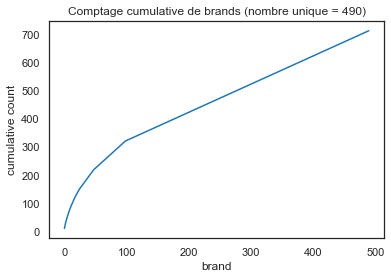

In [25]:
def plot_brands(df: pd.DataFrame):
    nb_brands = df['brand'].nunique()
    df['brand'].value_counts(normalize=False).cumsum(
    ).reset_index(drop=True).plot(kind='line')
    ax = plt.gca()
    # ax.tick_params(labelbottom=False)
    ax.set_xlabel('brand')
    ax.set_ylabel('cumulative count')
    plt.title(f'Comptage cumulative de brands (nombre unique = {nb_brands})')


plot_brands(df_data)
to_png()


"Top_20_brands_de_l'echantillon__[Autres_valeurs_=_582].png"


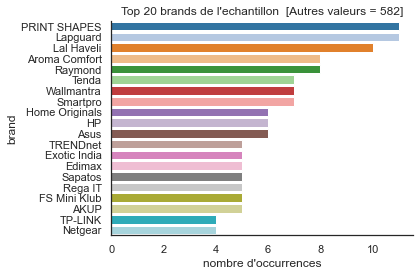

In [26]:
def top_n_freq(df: pd.DataFrame, col, nb=10, others=True, normalize=False):
    """
    Conter la fréquence des n tags plus fréquents
    return: value_counts comme un dataframe
    """
    nb = max(1, nb)
    counts_df = (df[col].value_counts(normalize=normalize)
                 .to_frame(name='freq')
                 .rename_axis(col)
                 )
    nb = min(nb, len(counts_df))
    top_n = counts_df.head(nb).copy()
    if others:
        top_n.loc['other', 'freq'] = counts_df.iloc[nb:, 0].sum()
    return top_n.reset_index()


def plot_bar_top_n(df: pd.DataFrame, col, nb=20, others=True, normalize=False, sort_values=False, palette=None,
                   ylabel=None, titre='', soustitre='', figsize=None):
    """Plot most frequent values of column as a bar chart, either as count or frequency"""
    data = top_n_freq(df, col, nb, others, normalize).copy()
    # print(data.columns.to_list())
    ax = None
    if not figsize is None:
        _, ax = plt.subplots(figsize=figsize)
    other_count = 0
    if others:
        filter_other = data[col] == 'other'
        other_count = data[filter_other]['freq'].values.sum()
        data = data[~filter_other]
    if sort_values:
        data = data.sort_values(by=col)
    if normalize:
        ax = sns.barplot(y=data[col], x=data['freq']
                         * 100, palette=palette, ax=ax)
        ax.set_xlabel('fréquence (%)')
    else:
        ax = sns.barplot(y=data[col], x=data['freq'], palette=palette, ax=ax)
        ax.set_xlabel("nombre d'occurrences")

    autres = ''
    if others and (other_count > 0):
        if normalize:
            other_count = f'{other_count * 100:.2f} %'
        else:
            other_count = f'{int(other_count)}'
        autres = f' [Autres valeurs = {other_count}]'
    if ylabel:
        ax.set_ylabel(ylabel)
    sns.despine()
    if len(titre) > 0:
        plt.suptitle(titre, y=1.05)
    plt.title(f'{soustitre} {autres}')
    plt.tight_layout()


plot_bar_top_n(df_data, 'brand', nb=20,
               soustitre="Top 20 brands de l'echantillon")
to_png()


In [27]:
df_data[['brand']].join(categ_level_1).value_counts().head(10)


brand           0                         
PRINT SHAPES    Computers                     11
Lapguard        Computers                     11
Lal Haveli      Home Decor & Festive Needs    10
Aroma Comfort   Home Furnishing                8
Raymond         Home Furnishing                8
Smartpro        Computers                      7
Tenda           Computers                      7
Home Originals  Home Furnishing                6
HP              Computers                      6
Asus            Computers                      6
dtype: int64

Le nom du brand aidera la classification (Netgear, Asus, HP seront classifiés dans la catégorie 'Computers')


### 2.3.3 Product name, description


In [28]:
df_data['product_name'].nunique()


1050

In [29]:
df_data.loc[0:3, ['brand', 'product_name', 'description']]


,brand,product_name,description
0,Elegance,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
1,Sathiyas,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
2,Eurospa,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
3,SANTOSH ROYAL FASHION,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...


On voit que le `brand` et `product_name` sont inclus dans `description` :

- ces 2 champs peuvent être supprimés
- on les garde pour voir si on peut categoriser seulement basés sur brand ou nom du produit


### 2.3.4 Product specifications

La colonne `product_specifications` contient des key-value pairs pour les spécifications des produits


In [30]:
df_data.loc[0, ['product_specifications']].values


array(['{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'],
      dtype=object)

number of unique specification_keys : 430
"Top_Specification_Keys__[Autres_valeurs_=_2795].png"


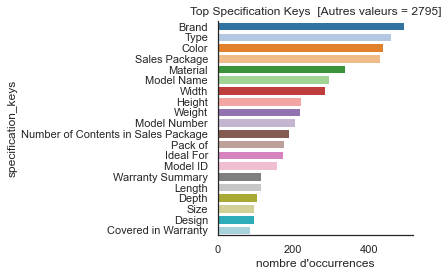

In [31]:
import json


def get_spec_keys(spec_text):
    try:
        items = json.loads(spec_text)
        return [item['key'] for item in items]
    except:
        return np.NaN


specification_keys = (df_data['product_specifications']
                      .str.replace('=>', ':')
                      .str.lstrip('{"product_specification":')
                      .str.rstrip('}')
                      .map(lambda x: get_spec_keys(x))
                      .rename('specification_keys')
                      )

spec_keys = specification_keys.explode().to_frame()

print(
    f"number of unique specification_keys : {spec_keys['specification_keys'].nunique()}")

plot_bar_top_n(spec_keys, 'specification_keys',
               soustitre='Top Specification Keys')
to_png()


Il semble que les `value` de chaque key-value pair sont inclus dans le champs `description`

- donc on peut supprimer ce champ.


### 2.3.5 Dates des échantillons (crawl_timestamp)

- Est-ce que les données sont comparables (ils viennent des même dates) ?
- Les echantillons vient d'un periode de 7 mois


"Distribution_des_dates_des_données.png"


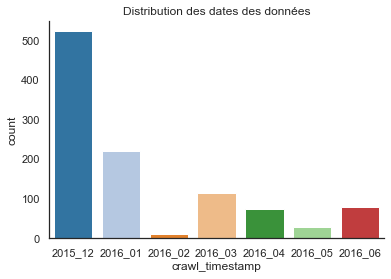

In [32]:
sns.countplot(x=pd.to_datetime(
    df_data['crawl_timestamp']).dt.strftime('%Y_%m').sort_values())
sns.despine()
plt.title('Distribution des dates des données')
to_png()


### 2.3.6 Distribution des prix

Les colonnes `retail_price` et `discounted_price` peuvent aider à classifier les produits entre les catégories, car on attend que des produits de soins sont moins chers que les ordinateurs, par exemple

Neanmoins, comme les données vient de dates différents, on évite d'utiliser le prix pour la classification


"Distribution_de_prix_par_catégorie_(échelle_logarithmique).png"


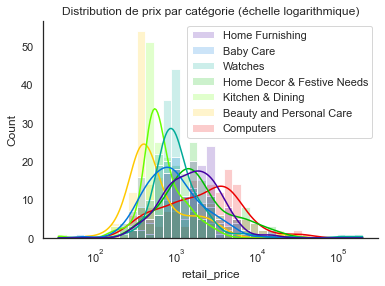

In [33]:
categ_level_1 = df_data['product_category_tree'].str.lstrip(
    '["').str.rstrip('"]').str.split(' >>', expand=True).iloc[:, 0]

sns.histplot(data=df_data, x='retail_price', hue=categ_level_1,
             palette='nipy_spectral',
             alpha=0.2,
             log_scale=True,
                     kde=True)
sns.despine()
plt.title(f'Distribution de prix par catégorie (échelle logarithmique)')
to_png()


## 2.4 Elimination des colonnes non-pertinentes au problématique

Avant de faire du feature engineering, on supprime les colonnes non-utilisées pour classification


In [34]:
print(list(df_data.columns))


['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


In [35]:
def drop_unused_columns(df):
    """supprimer les colonnes qui ne sont pas pertinentes"""
    colonnes_non_pertinentes = ['uniq_id','crawl_timestamp', 'product_url', 'retail_price', 'discounted_price',
                                'is_FK_Advantage_product', 'product_rating', 'overall_rating', 'product_specifications']
    cols_to_drop = cols_in_df(df_cleaned, colonnes_non_pertinentes)
    print (f'dropping {len(cols_to_drop)} unused columns')
    return df.drop(columns=cols_to_drop)


df_cleaned = (
    df_data
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
)

print (f'{df_data.shape} --> {df_cleaned.shape}')


dropping 9 unused columns
(1050, 15) --> (1050, 6)


# 3. Feature engineering / preprocessing

Les features à créer pour classifier les textes:

- préparation des **catégories** à partir du `product_category_tree`
- préparation des **descriptions nettoyées** pour entrer dans des modèles
- création des **topics** (sujets) basé sur ces descriptions nettoyés (pour comparer avec les catégories de `product_category_tree`)


## 3.1 Préparation des catégories

Features à créer à partir du `product_category_tree` :

- `categ_level_1` : les catégories à la racine de l'arbre
- `categ_level_2` : les sous-catégories (divisions dans `categ_level_1`)
- `categ_level_3` : les mini-catégories (divisions dans `categ_level_2`)
- etc


In [36]:
def remove_brackets(node: str):
    node = node.replace('["', '').replace('"]', '')
    return node


def create_categ_level(df):
    if not 'product_category_tree' in df.columns:
        return df
    else:
        df_cat = (df['product_category_tree']
                  .map(lambda x: remove_brackets(x))
                  .str.split(' >> ', expand=True))
        print(f'create_categ_level, shape= {df_cat.shape}')
        depth = len(df_cat.columns)
        df_cat.columns = [f'categ_level_{i}' for i in range(1, depth+1)]
        return pd.concat([df, df_cat], axis=1)


df_cleaned = (
    df_data
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
    .pipe(create_categ_level)
)


dropping 0 unused columns
create_categ_level, shape= (1050, 7)


### 3.1.1 Categories - niveau 1

- On va d'abord essayer de classifier par niveau 1


['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']
"Catégories_de_niveau_1_.png"


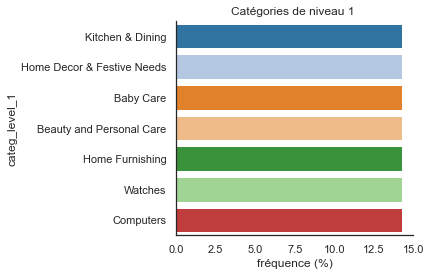

In [37]:
print(df_cleaned['categ_level_1'].unique().tolist())
plot_bar_top_n(df_cleaned, 'categ_level_1', normalize=True,
               soustitre='Catégories de niveau 1')
to_png()


### 3.1.2 Catégories - niveau 2


62
"Catégories_de_niveau_2__[Autres_valeurs_=_16-67_%].png"


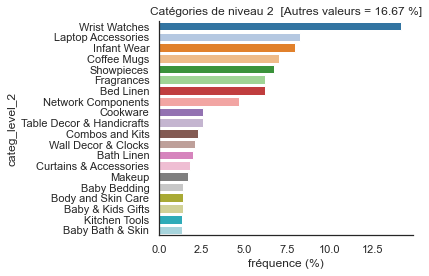

In [38]:
print(df_cleaned['categ_level_2'].nunique())
plot_bar_top_n(df_cleaned, 'categ_level_2', normalize=True,
               soustitre='Catégories de niveau 2')
to_png()


In [39]:
pd.concat([df_cleaned[['categ_level_2', 'categ_level_1']].value_counts().head(20),
           df_cleaned[['categ_level_2', 'categ_level_1']].value_counts(
).cumsum().head(20).rename('cum_sum'),
], axis=1)


,,0,cum_sum
categ_level_2,categ_level_1,,
Wrist Watches,Watches,149,149
Laptop Accessories,Computers,87,236
Infant Wear,Baby Care,84,320
Coffee Mugs,Kitchen & Dining,74,394
Showpieces,Home Decor & Festive Needs,71,465
Bed Linen,Home Furnishing,65,530
Fragrances,Beauty and Personal Care,65,595
Network Components,Computers,49,644
Table Decor & Handicrafts,Home Decor & Festive Needs,27,671


Pour l'arbre de categories, même s'il y a 62 catégories de niveau 2, environ 90% des produits sont dans les 20 plus grands catégories de niveau 2.

- On peut aussi evaluer la performance de classification à niveau 2, pour mieux comprendre les descriptions qui sont les mieux classifiés dans chaque catégorie principal.


### 3.1.3 Catégories - niveau 3


241
"Catégories_de_niveau_3__[Autres_valeurs_=_45-37_%].png"


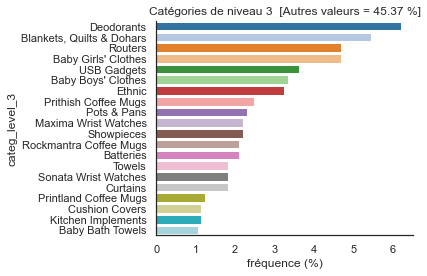

In [40]:
print(df_cleaned['categ_level_3'].nunique())
plot_bar_top_n(df_cleaned, 'categ_level_3', normalize=True,
               soustitre='Catégories de niveau 3')
to_png()


Avec seulement 1050 données, il sera très difficile de classifier entre 241 différent catégories de niveau 3.

- Par exemple, distinguer entre les marques de 'Coffee Mugs'


## 3.2 Préparation (preprocessing) des déscriptions des données

On essaie d'utiliser le champ `description` des produits pour les classifier dans les catégories de niveaux 1, 2, 3...

Il faut préparer les déscriptions avant de les fournir aux modèles de machine learning :

- mettre tout en minuscule
- retirer les mots de liaison
- retirer la ponctuation
- enlever les chiffres (si besoin)
- transformer les phrases en liste de tokens (en liste de mots)
- retirer mots de liaison ou qui n’apportant pas de sens (**stopwords**)
- lemmatizer
- reformer les phrases avec les mots restants

#### Réferences

- <https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/>


### 3.2.1 Features à créer à partir du `description` :

Chaque modèle a des requisites différents:

- `sentence_bow` : descriptions en minuscule, sans mots inutiles, mais pas lemmatizés pour BOW (Bag-of-Words) et TF-IDF (term frequency-inverse document frequency)
  - On utilisera ces 'bag-of-words' pour les 'baseline' model
- `sentence_bow_lem` : traitement de `sentence_bow`, lemmatizés pour BOW, TF-IDF et Word2Vec
- `sentence_dl` : descriptions nettoyés


#### Options pour nettoyage :

- bibliotheque NLTK
- bibliothèque gensims.utils
- Notre propre bibliothèque


#### 3.2.1.2 Import de NLTK pour nettoyage des champs de texte

On utilise la librairie nltk (Natural Language Toolkit), pour aider la nettoyage

On télecharge les stopwords, ponctuation et lemmatization

- <https://www.nltk.org/data.html>


In [41]:
import nltk

# stopwords
nltk.download('stopwords')
# punctuation
nltk.download('punkt')
# lemmatization
nltk.download('wordnet')
# Open Multilingual Wordnet Project lemmatizations
nltk.download('omw-1.4')
pass

# definir la langue qu'on veut utiliser pour nettoyer le champ de texte `description`
NTLK_LANGUAGE = 'english'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 3.2.1 Mots fréquents dans les descriptions

Avant nettoyage des descriptions, on regard les mots les plus utilisés 

In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

STOP_WORDS_EN = list(set(stopwords.words('english')))


def word_filter(list_words, stop_w=STOP_WORDS_EN):
    return [w for w in list_words if not w in stop_w]

# 
tokenizer = nltk.RegexpTokenizer(r'[a-z]+')


def topwords(sentences: pd.Series,
             token_fct=tokenizer.tokenize,
             filter_fct=word_filter,
             show_freq=False,
             nb=10) -> pd.DataFrame:
    corpus = sentences.str.lower().map(lambda x:token_fct(x))
    corpus = corpus.map(lambda x:filter_fct(x)).explode()
    freqwords = corpus.value_counts()
    df_freq_words = freqwords.head(nb).to_frame(
        'freq').rename_axis('word').reset_index()
    if show_freq ==False:
        # df_freq_words=df_freq_words.reset_index()  
        # df_freq_words['seq']= df_freq_words['seq'].astype(int)        
    # else:
        df_freq_words=df_freq_words.drop('freq',axis=1).T       

    return df_freq_words

print("mots plus fréquent dans 'product_name'")
print(topwords(df_cleaned['product_name']))
print('----------------------------')
print("mots plus fréquent dans 'description'")
print(topwords(df_cleaned['description']))
topwords(df_cleaned['description'],nb=20, show_freq=True)

mots plus fréquent dans 'product_name'
          0    1       2   3          4     5      6    7        8    9
word  watch  set  analog  cm  showpiece  baby  combo  men  ceramic  mug
----------------------------
mots plus fréquent dans 'description'
       0         1     2    3         4     5         6        7            8  \
word  rs  products  free  buy  delivery  cash  shipping  genuine  replacement   

       9  
word  cm  


,word,freq
0,rs,911
1,products,631
2,free,618
3,buy,581
4,delivery,567
5,cash,564
6,shipping,564
7,genuine,564
8,replacement,559
9,cm,558


On voit que les 20 mots les plus fréquents ne semblent pas déscriptifs d'une catégorie spécifique, sauf le mot 'watch'
- ils sont plutot les mots de publicité, dimensions ou couleur.

On verifie si ces mots sont présents plus dans chaque catégorie

In [43]:

def topwords_by_category(df: pd.DataFrame,
                   categ_col='categ_level_1',
                   desc_col='description',
                   stop_w=stopwords,
                   show_freq=False,
                   nb=10) -> pd.DataFrame:
    """
    Trouver les mots les plus fréquents dans desc_col, grouped by categ_col
    - if show_freq=True, renvoie un dataframe avec columns ={categorie, seq, word, freq}
    - if show_freq=False, renvoie un dataframe avec index=categorie, columns =[0..nb], values = words"""
    
    df_top = pd.DataFrame({}, columns=[categ_col])

    categories = df[categ_col].unique()
    for categ in categories:
        item_descriptions = df[df[categ_col] == categ][desc_col]
        df_categ_words = topwords(
            item_descriptions, nb=nb, show_freq=show_freq)
        df_categ_words[categ_col] = categ
        df_top = df_top.append(df_categ_words, ignore_index=True)        

    return df_top

topwords_by_category(df_cleaned, desc_col='description')


,categ_level_1,0,1,2,3,4,5,6,7,8,9
0,Home Furnishing,cm,rs,cotton,pack,cover,buy,products,free,design,delivery
1,Baby Care,baby,cotton,details,girl,fabric,dress,specifications,ideal,general,rs
2,Watches,watch,analog,men,rs,day,online,discounts,flipkart,india,shipping
3,Home Decor & Festive Needs,cm,showpiece,rs,products,best,free,buy,day,online,prices
4,Kitchen & Dining,mug,ceramic,coffee,perfect,rs,mugs,material,ml,day,features
5,Beauty and Personal Care,flipkart,com,rs,products,set,free,combo,replacement,delivery,cash
6,Computers,laptop,replacement,usb,warranty,rs,adapter,free,battery,power,guarantee


Les mots de publicité sont présent plus dans certains catégories
- ils sont des faux indicateurs de catégorie, car probablement ajoutés si le produit manque de déscription, ou après catégorisation du produit.

On compare avec les mots les plus fréquents dans 'product_name'

In [44]:
topwords_by_category(df_cleaned, desc_col='product_name')

,categ_level_1,0,1,2,3,4,5,6,7,8,9
0,Home Furnishing,cotton,single,abstract,double,floral,cover,blanket,comforters,quilts,multicolor
1,Baby Care,baby,girl,boy,dress,cotton,set,printed,shirt,blue,sticker
2,Watches,watch,analog,men,women,boys,sonata,maxima,digital,girls,gold
3,Home Decor & Festive Needs,showpiece,cm,wall,inch,rice,lights,haveli,lal,brass,wooden
4,Kitchen & Dining,mug,ceramic,prithish,l,rockmantra,kadhai,printland,design,ml,pizza
5,Beauty and Personal Care,combo,set,kit,cream,e,jewellery,spf,massage,vanity,fruit
6,Computers,usb,laptop,cell,led,battery,light,n,hp,router,dv


On démande si classification marchera mieux sur product_name, car c'et plus propre.

In [45]:
# seed = np.random.randint(0, 1050)
seed = 18
print(f"[{seed}] : {df_data['product_name'][seed]}")
print(f"[{seed}] : {df_data['description'][seed]}")


[18] : Franck Bella FB74C Analog Watch  - For Boys, Men
[18] : Franck Bella FB74C Analog Watch  - For Boys, Men - Buy Franck Bella FB74C Analog Watch  - For Boys, Men  FB74C Online at Rs.780 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


### 3.2.3 Suppression de la publicité "flipkart" (adwords)

On voit que beaucoup des descriptions contient des phrases qui n'ont rien à voir avec le produit.

Pour les produits qui n'ont pas une déscription ou specification, peut-être flipkart ont ajouté ces phrases de publicité pour ne laisse pas l'espace de déscription vide


In [46]:
print(df_data['description'][795])
print(df_data['description'][263])
print(df_data['description'][746])


Rana Watches Bw-Prsmd Barbie Analog Watch  - For Girls - Buy Rana Watches Bw-Prsmd Barbie Analog Watch  - For Girls  Bw-Prsmd Online at Rs.199 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Buy Woodino Handicrafts Showpiece  -  6.5 cm for Rs.399 online. Woodino Handicrafts Showpiece  -  6.5 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


Par exemple:

> '**Buy** eCraftIndia Floral Cushions Cover at Rs. 404 **at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!**'

Ces phrases font du bruit, et réduit la discrimination entre les produits


In [47]:
ADVERTS = [
    'Buy', 'Only Genuine Products', '!', 'Cash On Delivery', 'Free Shipping', '30 Day Replacement Guarantee',
    'Online', 'at Flipkart.com', 'from Flipkart.com', 'Flipkart.com', 'best prices', 'Lowest Prices',
    'Great Discounts', 'in India Only',
]


def get_useless_adwords(df, adverts=ADVERTS):
    """
    Trouve les phrases de publicité dans les descriptions, qui ne décrit
    pas le produit
     """
    df = df.copy()
    ad_cols = []
    for idx, ad in enumerate(adverts):
        ad_col = f'AD_{idx}'
        ad_cols.append(ad_col)
        df[ad_col] = df['description'].str.lower().str.contains(ad.lower())

    print(df[ad_cols].sum(axis=0))


get_useless_adwords(df_data)


AD_0     578
AD_1     564
AD_2     435
AD_3     564
AD_4     564
AD_5     469
AD_6     390
AD_7     226
AD_8     150
AD_9     384
AD_10    185
AD_11     17
AD_12    134
AD_13    134
dtype: int64


#### Suppression des phrases de publicité dans les descriptions

Les publicités semble être ajoutés come phrases

- on les supprime ici comme une phrase

Note: Un alternatif sera d'ajouter les mots aux 'stopwords', mais 
- on risque de perdre le mêmes mots hors du contexte des publicités 
- cette procédure n'est pas appélée dans la prétraitement de deep learning.


In [48]:
import re


def remplace(sentence: str, old_str: str, new_str: str = ' ', case_sensitive=False) -> str:
    """
    Remplace une chaine dans phrase avec une nouvelle chaine
    """
    if case_sensitive:
        return sentence.replace(old_str, new_str)
    else:
        return re.sub(re.escape(old_str), new_str, sentence, flags=re.IGNORECASE)


def remove_useless_adwords(sentence: str, adverts=ADVERTS):
    """supprime les phrases de publicité dans UNE description"""
    for ad in adverts:
        sentence = remplace(sentence, ad, ' ')
    return sentence


TEST_ADVERTS = df_data['description'][746]
print(TEST_ADVERTS)
TEST_DESCRIPTION_1 = remove_useless_adwords(TEST_ADVERTS)
print(TEST_DESCRIPTION_1)


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!
  eCraftIndia Floral Cushions Cover at Rs. 404  .  .  .   


### 3.2.4 Suppression des prix dans la déscription des produits

On peut considerer que le prix n'est pas un déscription du produit:

- Les produits ont été obtenu à des dates divers
- La prix dépend du vendeur, date, dévises..


In [49]:

def remove_prices(sentence: str) -> str:
    """Supprimer les prix dans les descriptions"""
    # \bRs.[0-9]*\.[0-9]*\b , tested at https://regex101.com/
    if isinstance(sentence, list):
        sentence = (' ').join(sentence)
    # supprime l'espace entre Rs. et le montant, si besoin
    sentence = remplace(sentence, 'Rs. ', 'Rs.')
    sentence = remplace(sentence, 'at Rs.', 'Rs.')
    sentence = remplace(sentence, 'only for Rs.', 'Rs.')
    sentence = remplace(sentence, 'for Rs.', 'Rs.')
    sentence = remplace(sentence, 'Price Rs.', 'Rs.')
    sentence = remplace(sentence, 'Price:', ' ')
    # si le montant est en decimales
    sentence = re.sub(r'\b[Rr]s.[0-9]*[\.,][0-9]*\b', ' ', sentence).strip()
    # si le montant est sans point decimal
    sentence = re.sub(r'\b[Rr]s.[0-9]*\b', ' ', sentence).strip()
    # suppression des double espaces laissés par suppression des mots
    sentence = re.sub('\s+', ' ', sentence)
    return sentence


print(TEST_DESCRIPTION_1)
TEST_DESCRIPTION_2 = remove_prices(TEST_DESCRIPTION_1)
print(TEST_DESCRIPTION_2)


  eCraftIndia Floral Cushions Cover at Rs. 404  .  .  .   
eCraftIndia Floral Cushions Cover . . .


#### Test des procedures pour supprimer les publicités et prix

Les procedures ci-dessus sont améliorés en testant aléatoirement sur le jeu de données


In [50]:
# seed = np.random.randint(0, 1050)
seed = 237
test_description = df_data['description'][seed]
test_cleaned = remove_prices(remove_useless_adwords(test_description))
print(f'original [{seed}] : \n{test_description}')
print(f'cleaned [{seed}] : \n{test_cleaned}')


original [237] : 
Buy Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm for Rs.6949 online. Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
cleaned [237] : 
Lal Haveli Iron Wall Decorative Musician Showpiece - 50.8 cm . Lal Haveli Iron Wall Decorative Musician Showpiece - 50.8 cm at with & . . .


### 3.2.4 Tokenization

Tokenization est le processus de convertir un chaine en tokens (en général, mots et ponctuation)


In [51]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from typing import List
import string
import re

def lower_start_fct(list_words: List[str]) -> List[str]:
    """lower case et alpha"""
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


def tokenizer_fct(sentence: str, language=NTLK_LANGUAGE, sans_ads=False) -> List[str]:
    """
    return tokens as space-separated string
    - alternative : `tokens = gensim.utils.simple_preprocess(sentence)`
    """
    if sans_ads:
        sentence = remove_useless_adwords(sentence)
        sentence = remove_prices(sentence)

    sentence = re.sub('\S*@\S*\s?', '', sentence)  # remove emails
    sentence = re.sub('\s+', ' ', sentence)  # remove newline chars
    sentence = re.sub("\'", "", sentence)  # remove single quotes
    # supprime le ponctuation
    sentence = "".join([i.lower() for i in sentence if i not in string.punctuation])
    # supprime les valeurs numériques
    sentence = ''.join(i for i in sentence if not i.isdigit())
    # assure words are recognised
    sentence = sentence.lower()
    sentence_clean = (sentence.replace('-', ' ')
                      .replace('+', ' ')
                      .replace('/', ' ')
                    #   .replace('.', '. ')
                      .replace(',', ', ')
                      .replace('#', ' '))
    word_tokens = word_tokenize(sentence_clean, language=language)
    return word_tokens


print(tokenizer_fct(TEST_ADVERTS, sans_ads=True))


['ecraftindia', 'floral', 'cushions', 'cover']


### 3.2.5 Stop words

Les stopwords dans du contexte pour les autre mots.
On ne le supprime pas pour deep-learning comme BERT et USE

Pour les autres algorithmes :

- On supprime les stopwords de la librairie NLTK (dans la langue des déscriptions)
- on analyse les mots les plus fréquents qui reste

- On élimine :
  - les mots les plus fréquent non-discriminatoire (bruit)
  - les mots qui ne sont pas discriminatoire de produit ('key features', ')
  - les mots oubliés de publicité


In [52]:
from nltk.corpus import stopwords

STOP_WORDS_EN = list(set(stopwords.words('english')))
print(STOP_WORDS_EN[:40])


['yourselves', 'me', 're', "doesn't", 'then', 'but', "weren't", "don't", 'a', 'for', 'own', 'how', 'through', 'off', 'my', 'she', 'itself', 'if', 'when', 'had', 'where', 'between', 'doing', 'aren', 'the', 't', 'more', "you'd", 'about', 'below', 'or', "should've", 'any', "hadn't", "you've", 'nor', "shouldn't", 'its', 'wouldn', 'on']


In [53]:
from typing import List


def lower_start_fct(list_words: List[str]) -> List[str]:
    """lower case et alpha"""
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


def stop_word_en_filter(list_words: List[str], stop_w=STOP_WORDS_EN) -> List[str]:
    """Stop words"""
    filtered_w = [w for w in list_words if not w in stop_w]
    return filtered_w


print(stop_word_en_filter(tokenizer_fct(TEST_ADVERTS, sans_ads=True)))


['ecraftindia', 'floral', 'cushions', 'cover']


#### Trouver les mots le plus fréquents dans le corpus

On cherche les mots fréquents non-discriminatoires.

- Certain des mots fréquents sont utiles pour classification, d'autres non


In [54]:
from typing import List

def get_corpus_freq(descriptions:pd.Series, nb=20, stop_w=STOP_WORDS_EN)->List[str]:
    word_lists=descriptions.str.lower().map(lambda x:tokenizer_fct(x))
    corpus=word_lists.explode()
    print(f'unique words: {corpus.nunique()}')
    corpus_2=pd.Series(stop_word_en_filter(corpus,stop_w=stop_w))
    most_freq=corpus_2.value_counts()[:nb]
  
    return most_freq


cleaned_corpus = df_data['description'].map(lambda x:remove_prices(remove_useless_adwords(x)))

most_freq=get_corpus_freq(cleaned_corpus, nb=40)
print(f'most_freq: {most_freq.index.to_list()}')
    

unique words: 5681
most_freq: ['cm', 'features', 'watch', 'mug', 'baby', 'pack', 'color', 'material', 'set', 'type', 'box', 'general', 'cotton', 'package', 'sales', 'analog', 'number', 'warranty', 'quality', 'girls', 'details', 'brand', 'product', 'model', 'key', 'ceramic', 'design', 'laptop', 'fabric', 'showpiece', 'made', 'perfect', 'boys', 'inch', 'men', 'usb', 'size', 'specifications', 'multicolor', 'dimensions']


#### Création d'une liste de stopwords spécifique pour ce corpus

On ajoute iterativement des stopwords spécifiques de ce corpus à fin de reduire les mots de bruit dans le corpus.
- lest mots les plus fréquents
- les mots le moins fréquents
- les mots avec un score IDF (Inverse Document Frequency) très bas


- <https://kavita-ganesan.com/tips-for-constructing-custom-stop-word-lists/> 


In [55]:
stop_frequent = topwords(df_cleaned['description'],nb=10)
stop_frequent = stop_frequent.T['word'].tolist()
if 'watch' in stop_frequent:
    stop_frequent.remove('watch')
stop_frequent.extend(['details'])
print(stop_frequent)


['rs', 'products', 'free', 'buy', 'delivery', 'cash', 'shipping', 'genuine', 'replacement', 'cm', 'details']


In [56]:


def get_low_idf_words(sentences:pd.Series):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tf = TfidfVectorizer(use_idf=True)
    sentences= sentences.map(lambda x:(' ').join(stop_word_en_filter(tokenizer_fct(x))))
    tf.fit_transform(sentences)
    df_idf = pd.DataFrame({'word':tf.get_feature_names_out(),
     'idf': tf.idf_})
    return df_idf.sort_values(by='idf')

idf = get_low_idf_words(df_cleaned['description'])
idf.head(30).T




,4204,1963,3842,667,1303,2060,748,4412,1255,4072,2194,3403,1900,3806,2053,1807,568,5133,4243,3486,3346,459,952,582,3485,3809,3004,2649,908,2165
word,rs,free,products,buy,delivery,genuine,cash,shipping,day,replacement,guarantee,online,flipkartcom,price,general,features,box,type,sales,package,number,best,color,brand,pack,prices,material,key,cm,great
idf,1.14,1.57,1.58,1.60,1.62,1.62,1.62,1.62,1.73,1.76,1.80,1.99,2.00,2.12,2.31,2.38,2.44,2.54,2.57,2.57,2.58,2.59,2.59,2.62,2.62,2.63,2.64,2.65,2.72,2.84


In [57]:
stop_low_idf= idf.head(26)['word'].to_list()
# on garde 'watch' pour catégorie 'watches'
if 'watch' in stop_low_idf: 
    stop_low_idf.remove('watch')
if 'set' in stop_low_idf: 
    stop_low_idf.remove('set')
print (stop_low_idf)

['rs', 'free', 'products', 'buy', 'delivery', 'genuine', 'cash', 'shipping', 'day', 'replacement', 'guarantee', 'online', 'flipkartcom', 'price', 'general', 'features', 'box', 'type', 'sales', 'package', 'number', 'best', 'color', 'brand', 'pack', 'prices']


In [58]:
import time 

STOP_WORDS_BASIC = ['[', ']', ',', '.', ':', '!',
                    '?', '(', ')', '%', '&', "'", "''", "'s"]

# frequent
# stop_frequent = ['key', 'general', 'detail', 'details',
#                  'feature', 'features', 'specification', 'specifications']
stop_id = ['brand', 'product', 'products', 'id', 'model']
stop_pub = ['sales', 'price', 'warranty']
stop_adjectives = ['best', 'design', 'yes']


# STOP_WORDS_CUSTOM = [*stop_frequent, *stop_id, *stop_pub, *stop_adjectives]
# STOP_WORDS_CUSTOM = list(set([*stop_frequent,*stop_low_idf]))
STOP_WORDS_CUSTOM = list(set([*stop_low_idf]))
print(f'stop_words_custom : {STOP_WORDS_CUSTOM}')

timestr = time.strftime("%Y-%m-%d-%H.%M.%S")
pd.DataFrame(STOP_WORDS_CUSTOM).to_csv(f'{IMAGE_FOLDER}/stopwords_custom_{timestr}.csv')

STOP_WORDS_ALL = list(set([*STOP_WORDS_EN, *STOP_WORDS_BASIC, *STOP_WORDS_CUSTOM]))
most_freq = get_corpus_freq(cleaned_corpus, stop_w=STOP_WORDS_ALL, nb=40)
print(f'most_frequent other words: {most_freq.index.to_list()}')


stop_words_custom : ['online', 'products', 'brand', 'color', 'free', 'replacement', 'prices', 'shipping', 'sales', 'box', 'pack', 'best', 'package', 'type', 'price', 'number', 'cash', 'delivery', 'rs', 'genuine', 'general', 'features', 'flipkartcom', 'guarantee', 'buy', 'day']
unique words: 5681
most_frequent other words: ['cm', 'watch', 'mug', 'baby', 'material', 'set', 'cotton', 'analog', 'warranty', 'quality', 'girls', 'details', 'product', 'model', 'key', 'ceramic', 'design', 'laptop', 'showpiece', 'fabric', 'made', 'perfect', 'boys', 'inch', 'men', 'usb', 'size', 'specifications', 'ideal', 'multicolor', 'dimensions', 'skin', 'home', 'contents', 'x', 'combo', 'gift', 'water', 'women', 'printed']


In [59]:
stop_w_en = list(set([*STOP_WORDS_EN, *STOP_WORDS_BASIC]))

def freq_words(sentences: pd.Series, exclude=stop_w_en, include=None, nb=20, normalize=True) -> pd.DataFrame:
    """comptage frequence d'occurences de chaque mot"""

    corpus = ' '.join(sentences)

    corpus = tokenizer_fct(corpus)

    # exclure les stopwords standard - trop fréquent
    if not exclude is None:
        corpus = [w for w in corpus if not w in exclude]

    word_count= ((pd.Series(corpus)
                .value_counts(normalize=normalize)
                 .to_frame(name='freq'))
                 .rename_axis('word')
                 .reset_index()
                 )
    if normalize:
        word_count['freq'] *= 100
    else:
        word_count = word_count.rename(columns={'freq':'count'}) 
    if not include is None: 
        word_count=word_count[word_count['word'].isin(include)]
    else:
        nb= min(nb,len(word_count))
        word_count=word_count.head(nb)
    return word_count.T


freq_words(df_data['description'].str.lower(), include=STOP_WORDS_CUSTOM)

,0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,18,19,22,24,25,27,28,30,35,36,45
word,rs,products,free,buy,delivery,shipping,genuine,cash,replacement,day,flipkartcom,guarantee,online,features,price,color,pack,type,box,general,package,sales,number,brand,best,prices
freq,1.65,1.15,1.11,1.05,1.03,1.02,1.02,1.02,1.01,0.97,0.85,0.85,0.72,0.71,0.64,0.57,0.57,0.55,0.52,0.52,0.49,0.47,0.45,0.42,0.42,0.37


In [60]:
freq_words(df_data['description'].str.lower(), include=STOP_WORDS_CUSTOM, normalize=False)


,0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,18,19,22,24,25,27,28,30,35,36,45
word,rs,products,free,buy,delivery,shipping,genuine,cash,replacement,day,flipkartcom,guarantee,online,features,price,color,pack,type,box,general,package,sales,number,brand,best,prices
count,913,635,612,581,567,564,564,564,559,538,472,471,396,394,351,317,317,303,289,288,268,261,249,232,230,206


In [61]:
# from nltk import FreqDist


def freq_words_by_category(df: pd.DataFrame,
                   categ_col='categ_level_1',
                   desc_col='description',
                   exclude=stop_w_en,
                   include=STOP_WORDS_CUSTOM,
                   nb=10) -> pd.DataFrame:
    """
    Trouver la fréquence des mots dans desc_col, grouped by categ_col
    exclude sont les mots à exclure du comptage
    include sont les mots à inclure dans la liste
    - si include=None, renvoie un la fréquence des nb mots les plus fréquents
    - si include, renvoie un dataframe avec index=categorie, columns =[0..nb], values = words"""
    
    df_top = pd.DataFrame({}, columns=[categ_col])

    categories = df[categ_col].unique()
    for categ in categories:
        item_descriptions = df[df[categ_col] == categ][desc_col]
        df_categ_words = freq_words(item_descriptions, exclude=exclude, include=include, nb=nb).T.set_index('word').T
        df_categ_words[categ_col] = categ
        df_top = df_top.append(df_categ_words, ignore_index=True)        

    return df_top

custom_stop_words_by_category=freq_words_by_category(df_cleaned, desc_col='description',include=STOP_WORDS_CUSTOM)
custom_stop_words_by_category

,categ_level_1,rs,pack,products,buy,free,delivery,genuine,cash,flipkartcom,shipping,package,sales,color,features,price,brand,box,general,number,type,day,best,replacement,prices,online,guarantee
0,Home Furnishing,1.98,1.36,1.19,1.19,1.18,1.15,1.15,1.15,1.15,1.15,0.98,0.96,0.94,0.85,0.84,0.73,0.71,0.70,0.68,0.56,0.12,0.08,0.05,0.02,NaN,NaN
1,Baby Care,1.09,0.85,0.45,0.40,0.51,0.39,0.39,0.39,0.37,0.39,1.00,0.98,0.55,0.95,0.64,0.46,0.77,1.10,0.87,0.93,0.24,0.24,0.16,0.16,0.30,0.16
2,Watches,2.62,0.02,2.47,2.47,2.47,2.47,2.47,2.47,2.47,2.47,0.04,0.04,0.46,0.24,0.11,0.15,0.09,0.18,0.06,0.20,2.51,NaN,2.47,NaN,2.47,2.47
3,Home Decor & Festive Needs,1.53,0.44,1.01,0.90,0.91,0.84,0.83,0.83,NaN,0.83,0.52,0.47,0.73,0.67,0.75,0.35,0.56,0.36,0.62,0.44,0.89,0.95,0.83,0.86,0.86,0.83
4,Kitchen & Dining,1.38,0.69,0.67,0.56,0.56,0.51,0.51,0.51,0.05,0.51,0.29,0.29,0.46,0.91,0.87,0.30,0.44,0.38,0.30,0.51,0.96,0.64,0.51,0.51,0.49,0.50
5,Beauty and Personal Care,2.10,0.48,2.08,1.62,1.70,1.65,1.62,1.62,2.54,1.62,0.13,0.13,0.66,0.43,0.54,0.27,0.77,0.40,0.30,0.70,1.62,0.40,1.68,0.61,1.33,1.62
6,Computers,1.51,0.15,1.04,1.04,1.22,1.03,1.03,1.03,0.74,1.03,0.35,0.35,0.32,0.69,0.49,0.63,0.31,0.45,0.22,0.44,1.03,0.29,1.92,0.26,0.28,1.05


In [62]:
custom_stop_words_by_category=freq_words_by_category(df_cleaned, desc_col='product_name',include=STOP_WORDS_CUSTOM)
custom_stop_words_by_category

,categ_level_1,pack,box,buy,free,rs,color,products,day,best,replacement
0,Home Furnishing,0.11,0.11,0.11,0.11,NaN,NaN,NaN,NaN,NaN,NaN
1,Baby Care,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,NaN,NaN
2,Watches,NaN,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,NaN
3,Home Decor & Festive Needs,NaN,0.21,NaN,NaN,NaN,0.31,0.21,NaN,NaN,NaN
4,Kitchen & Dining,0.12,0.24,NaN,0.12,NaN,0.85,NaN,0.36,0.12,NaN
5,Beauty and Personal Care,0.87,0.58,NaN,0.10,NaN,0.39,NaN,NaN,NaN,NaN
6,Computers,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88


In [63]:
def stop_word_filter_fct(list_words: List[str], stop_w=STOP_WORDS_ALL) -> List[str]:
    """Stop words"""
    filtered_w = [w for w in list_words if not w in stop_w]
    return filtered_w

print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct("The movie was not good at all."))))

['movie', 'good']


In [64]:


print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct(df_data['description'][6]), stop_w=STOP_WORDS_ALL)))


['camerii', 'wm', 'elegance', 'analog', 'watch', 'men', 'boys', 'camerii', 'wm', 'elegance', 'analog', 'watch', 'men', 'boys', 'wm', 'india', 'great', 'discounts']


### 3.2.5 Lemmatization


In [65]:
from typing import List
from nltk.stem import WordNetLemmatizer


def lemma_fct(list_words: List[str]) -> List[str]:
    """
    Lemmatizer (base d'un mot)
    """
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# test de lemmatizer (bug: men -> man ?)
TEST_LEMMA = 'boys girls men and women shows lots of highs and lows qualities in inches'.split(
    ' ')
print(TEST_LEMMA)
print(lemma_fct(TEST_LEMMA))


['boys', 'girls', 'men', 'and', 'women', 'shows', 'lots', 'of', 'highs', 'and', 'lows', 'qualities', 'in', 'inches']
['boy', 'girl', 'men', 'and', 'woman', 'show', 'lot', 'of', 'high', 'and', 'low', 'quality', 'in', 'inch']


### 3.2.6 Préparation commune des traitements

Pour analyser catégoriser les descriptions


#### Création de feature `sentence_dl` pour deep learning

Les modèles de deep learning comme [BERT](https://arxiv.org/abs/1810.04805) et [USE](https://arxiv.org/abs/1803.11175) traitent les mots dans le contexte de leur phrases

- BERT : Bidirectional Encoder Representations from Transformers
- USE : Universal Sentence Encoder

Avec BERT et USE, il ne faut pas trop traiter les textes, sinon, vous perdez le contexte (racine, lemmatisation) ou modifier purement et simplement les textes (suppression des mots vides).

Les descriptions des produits semble déjà traités, donc on essayer d'eviter de supprimer les stopwords et lemmatization.


In [66]:
print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct("The movie was not good at all."))))

['movie', 'good']


In [67]:

def transform_dl_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le Deep learning 
    (USE et BERT)
    With BERT you don't process the texts; otherwise, you lose the context (stemming, lemmatization)
    or change the texts outright (stop words removal).
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    # sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


TEST_TRANSFORM = df_data['description'][142]
print('---Original------')
print(TEST_TRANSFORM)
print('---Transformed----')
transform_dl_fct(TEST_TRANSFORM)


---Original------
Rockmantra Abstracts 16 Ceramic Mug (5.5 l)
                         Price: Rs. 199
				
Size : 3.5" X 4"icg yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
Size : 3.5" X 4"icet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
---Transformed----


'rockmantra abstracts ceramic mug l give a thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too dishwasher and microwave safe product details and specifications material ceramic size x give a thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too dishwasher and microwave safe product details and specifications material ceramic size x'

#### Création de feature `sentence_bow`


In [68]:
from nltk.tokenize import sent_tokenize, word_tokenize


def transform_bow_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words
    (Countvectorizer et Tf_idf, Word2Vec)
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)
    
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


transform_bow_fct(TEST_TRANSFORM)


'rockmantra abstracts ceramic mug l give thrilling yet fresh start exclusive creation rockmantra mug porcelain crafting ensuring design stays permanent years come making perfect pick gift loved ones dishwasher microwave safe product details specifications material ceramic size x give thrilling yet fresh start exclusive creation rockmantra mug porcelain crafting ensuring design stays permanent years come making perfect pick gift loved ones dishwasher microwave safe product details specifications material ceramic size x'

#### Création de feature `sentence_bow_lem`


In [69]:

def transform_bow_lem_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words 
    avec lemmatization (Countvectorizer et Tf_idf, Word2Vec)
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


print(TEST_ADVERTS)
transform_bow_lem_fct(TEST_ADVERTS)


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


'ecraftindia floral cushion cover'

In [70]:
def transform_bow_lem_ads_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words 
    avec lemmatization (Countvectorizer et Tf_idf, Word2Vec)
    """
    # desc_text = remove_useless_adwords(desc_text)
    # desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


print(TEST_ADVERTS)
transform_bow_lem_ads_fct(TEST_ADVERTS)


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


'ecraftindia floral cushion cover'

### 3.2.7 Transformation de textes prêts pour les modèles


In [71]:

def transform_field(df: pd.DataFrame, text_col: str = 'description') -> pd.DataFrame:
    df = df.copy()
    df['sentence_bow'] = df[text_col].apply(lambda x: transform_bow_fct(x))
    df['sentence_bow_lem'] = df[text_col].apply(
        lambda x: transform_bow_lem_fct(x))
    df['product_name_bow_lem'] = df['product_name'].apply(
        lambda x: transform_bow_lem_fct(x))
    df['sentence_bow_lem_ads'] = df[text_col].apply(
        lambda x: transform_bow_lem_ads_fct(x))
    df['sentence_dl'] = df[text_col].apply(lambda x: transform_dl_fct(x))
    print(f'transform_field [{text_col}], df.shape={df.shape}')
    return df


df_cleaned = df_cleaned.pipe(transform_field)
df_cleaned.head(1)


transform_field [description], df.shape=(1050, 27)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categ_level_1,categ_level_2,categ_level_3,categ_level_4,categ_level_5,categ_level_6,categ_level_7,sentence_bow,sentence_bow_lem,product_name_bow_lem,sentence_bow_lem_ads,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,elegance polyester multicolor abstract eyelet door curtain,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,key features of elegance polyester multicolor abstract eyelet door curtain floral curtaineleganc...


### 3.2.9 Calcul du longeur des phrases (nombre de mots)

Certain modèles ont besoin de savoir le longueur des phrase comme hyper paramètre


In [72]:

def calc_length_bow(df: pd.DataFrame):
    df = df.copy()
    df['length_bow'] = df['sentence_bow'].apply(
        lambda x: len(word_tokenize(x)))
    print(f"max length bow : {df['length_bow'].max()}")
    df['length_dl'] = df['sentence_dl'].apply(lambda x: len(word_tokenize(x)))
    print(f"max length dl : {df['length_dl'].max()}")
    return df


## 3.3 Pipeline pour création des features 'sentence' pour les modeles


In [73]:

df_cleaned = (
    pd.read_csv(RAW_DATA, sep=',', encoding='UTF-8')
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
    .pipe(create_categ_level)
    .pipe(transform_field, 'description')
    .pipe(calc_length_bow))

df_cleaned.head(1)


dropping 9 unused columns
create_categ_level, shape= (1050, 7)
transform_field [description], df.shape=(1050, 18)
max length bow : 336
max length dl : 560


,product_name,product_category_tree,pid,image,description,brand,categ_level_1,categ_level_2,categ_level_3,categ_level_4,categ_level_5,categ_level_6,categ_level_7,sentence_bow,sentence_bow_lem,product_name_bow_lem,sentence_bow_lem_ads,sentence_dl,length_bow,length_dl
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",Elegance,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,elegance polyester multicolor abstract eyelet door curtain,key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...,key features of elegance polyester multicolor abstract eyelet door curtain floral curtaineleganc...,132,217


## 3.4 Verification des mots plus fréquents


In [74]:

print('---- bag-of-words ------')
get_corpus_freq(df_cleaned['sentence_bow'])
print('---- bag-of-words with lemmatization ------')
get_corpus_freq(df_cleaned['sentence_bow_lem'])
print('---- sentence for deep learning ------')
get_corpus_freq(df_cleaned['sentence_dl'])
pass


---- bag-of-words ------
unique words: 5544
---- bag-of-words with lemmatization ------
unique words: 5145
---- sentence for deep learning ------
unique words: 5681


### 3.4.1 Visualise comme word clouds

['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


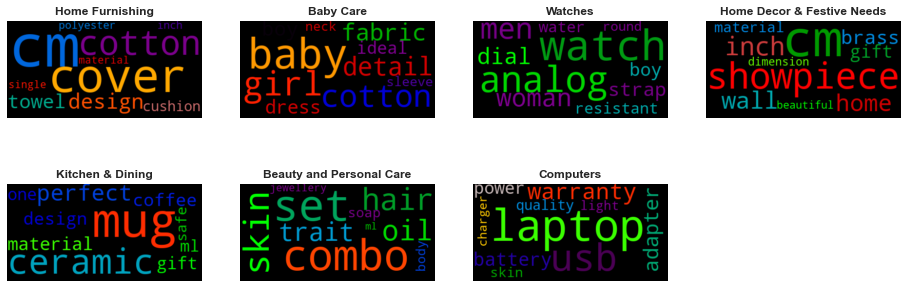

In [75]:
from wordcloud import WordCloud

def plot_wordcloud(sentences:pd.Series, cmap='bright', ax=None, nb=20):
    cloud = WordCloud(stopwords=None, background_color=None,
                        colormap=cmap)
    topwords:pd.DataFrame=freq_words(sentences, nb=nb).T.set_index('word')
    topword_dict=dict(zip(list(topwords.index), list(topwords['freq'])))
    # print (topword_dict)
    cloud.generate_from_frequencies(topword_dict)
    if ax is None:
        plt.figure()
        ax=plt.gca()
    ax.imshow(cloud,interpolation="bilinear")
    plt.axis("off")

def plot_wordclouds_by_categ(df, feature='sentence_bow_lem',categ_col='categ_level_1', 
cmap='nipy_spectral',nb=10):
    categories=df[categ_col].unique()
    print(categories)
    n_cols = 4
    n_rows = len(categories) // n_cols + (len(categories) % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    for n, category in enumerate(categories):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        sentences=df[df[categ_col]==category][feature]
        plot_wordcloud(sentences, ax=ax, cmap=cmap,nb=nb)
        plt.title(category, fontweight='bold')

    plt.subplots_adjust(hspace=0, wspace=0.2)

plot_wordclouds_by_categ(df_cleaned)

## 3.5 Enregistre les données préparées


In [76]:
os_make_dir(OUT_FOLDER)
df_cleaned.to_csv(f'{OUT_FOLDER}/data_cleaned.csv',
                  encoding='UTF-8', index=False)


## 3.6 Nettoyage des variables globales


In [77]:
del df_data
del df_cleaned


---


# 4. Fonctions communs pour modèles NLP

- Lecture de données
- Scoring des modèles
- Visualisation de metriques de performance
- Visualisation des clusters


## 4.1 Lecture des données


In [78]:
data_T = pd.read_csv(f'{OUT_FOLDER}/data_cleaned.csv')
print(data_T.shape)


(1050, 20)


### 4.1.1 Variables pour comparer les catégories


In [79]:
from sklearn.preprocessing import LabelEncoder
cat_encoder= LabelEncoder()

# list des catégories de niveau 1
l_cat = sorted(list(set(data_T['categ_level_1'])))
l_cat_num = cat_encoder.fit_transform(l_cat)

# map de catégories
cat_map=dict(zip(l_cat_num,l_cat))
print("catégories : ", cat_map)
cat_encoder.inverse_transform(l_cat_num)


y_cat_num = cat_encoder.fit_transform(data_T['categ_level_1'])
y_cat_txt =data_T['categ_level_1'].copy()



catégories :  {0: 'Baby Care', 1: 'Beauty and Personal Care', 2: 'Computers', 3: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 5: 'Kitchen & Dining', 6: 'Watches'}


In [80]:
cat_encoder.inverse_transform([1,0,5,6])

array(['Beauty and Personal Care', 'Baby Care', 'Kitchen & Dining',
       'Watches'], dtype=object)

## 4.2 Modélisation et évaluation des modèles:

- **Prétraitement** des données (choix de description , lemmatization, stopwords,...) - voir ci-dessus. On utilise 'feature' pour choisir la colonne des données prétraitées.

- **Extraction de features** (par Bag-of-Words, TF-IDF, Word2Vec etc)

- **Réduction de dimensions** (par t-SNE, PCA, NMF, truncatedSVD...)

- **Classification (clustering) non-supervisée sur les dimensions réduits** (Gridsearch des hyperparamètres, sans ou avec choix de nombre de clusters)
  - par Kmeans
  - par LDA
  - par NMF

- **Evaluation de performance**:
  - score davies_bouldin
  - score silhouette des clusters (sur des sous-echantillons --> écart type)
  - score stabilité des clusters (sur des sous-échantillons --> écart type)

- **Evaluation de correspondance avec les catégories définis**
  - ARI score
  - pourcentage des items mal classés
  - visualisation pour comparer les clusters sur les principaux dimensions
  - visualisation Sankey de correlations entre clusters

### 4.2.1 Scoring : performance d'un model

C'est compliqué a mettre en place un pipeline de preprocessing, feature extraction, dimension reduction, classification, scoring, car les librairies parfois retourne un matrice sparse, parfois pas. 

Ci-dessous, ma procédure génerique pour score d'un model 
- on varie parametre k pour evaluer le nombre de clusters pour un meilleur performance

On peut facilment ajouter un param_grid et faire un GridSearch sur tous les combinaisons des parametres :
```python
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)

    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        model.set_params(**params)
        model.fit...
```

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
import time

param_grid = {'n_clusters': range(4, 12)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_model(df: pd.DataFrame,
                feature='sentence_bow_lem',
                labels_true=None,
                document_preprocessor=None,
                feature_extractor=TfidfVectorizer(
                    stop_words='english', max_df=0.95, min_df=3),
                dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000,
                                       init='random', learning_rate=200, random_state=RANDOM_SEED),
                kmin=7, kmax=7):
    """Executer un traitement de données, extraire les features, réduire les dimensions, et faire du clustering
    Returns : scores, labels et matrice de 'reduced dimensions'
    """


    # preprocess (normally done)
    if document_preprocessor is None:
        documents=df[feature]
    else:
        documents= document_preprocessor.fit_transform(df[feature])

    # extract features
    start_fit_extract = time.time()
    features = feature_extractor.fit_transform(documents)
    fit_time_extract = round(time.time()-start_fit_extract, 2)
    print(
        f'Extract_features ({get_classname(feature_extractor)}), fit time = {fit_time_extract} s')

    # reduce dimensions
    start_fit_reduce = time.time()
    reduced_dimensions = dimension_reducer.fit_transform(features)
    fit_time_reduce = round(time.time()-start_fit_reduce, 2)
    print(
        f'Reduce dimensions ({get_classname(dimension_reducer)}), fit time = {fit_time_reduce} s')

    df_scores = pd.DataFrame({})

    for k in range(kmin, kmax+1):
        clusterer = KMeans(n_clusters=k)

        #
        start_fit_clf = time.time()
        clusterer.fit(reduced_dimensions)
        fit_time_clf = round(time.time()-start_fit_clf, 2)
        # print(f'Clusterer fit time = {fit_time_clf} s')

        labels_pred = clusterer.labels_
        cluster_sizes = (pd.Series(labels_pred).value_counts(
            normalize=True).values*100).astype(int)

        min_cluster_pct = pd.Series(
            labels_pred).value_counts(normalize=True).min()
        res = {'k': k,
               'min_cluster_pct': round(min_cluster_pct*100, 2),
               'distortion_score': round(getattr(clusterer, 'inertia_', 0), 0),
               'davies_bouldin': round(metrics.davies_bouldin_score(reduced_dimensions, labels_pred), 2),
               'calinski_harabasz': round(metrics.calinski_harabasz_score(reduced_dimensions, labels_pred), 2),
               'silhouette_score': round(metrics.silhouette_score(reduced_dimensions, labels_pred), 3),
               'fit_time_cluster': fit_time_clf
               }
        ARI = ''
        if not labels_true is None:
            res['ARI'] = round(metrics.adjusted_rand_score(
                labels_true, labels_pred), 3)
            ARI = f" ARI = {res['ARI']},"
        print(
            f"k={k}, fit: {fit_time_clf} s, silhouette= {res['silhouette_score']:.3},{ARI} cluster sizes = {cluster_sizes}")
        df_scores = df_scores.append(res, ignore_index=True)
   
    df_scores['feature_extraction'] = get_classname(feature_extractor)
    df_scores['dimension_reduction'] = get_classname(dimension_reducer)
    df_scores['classifier'] = get_classname(clusterer)
    df_scores['k']=df_scores['k'].astype(int)

    if kmin == kmax:
        # utilise les dernier labels car ils sont aussi les premiers
        return df_scores, labels_pred, reduced_dimensions
    else:
        # fourni les labels du meilleur k (on peut plus inferer best_k = labels.nunique())
        best_score_idx = df_scores['silhouette_score'].idxmax()
        best_k=df_scores.loc[best_score_idx,'k']
        clusterer = KMeans(n_clusters=best_k)
        clusterer.fit(reduced_dimensions)
        labels_pred=clusterer.labels_
        return df_scores, labels_pred, reduced_dimensions


scores, labels, red_dim = score_model(data_T, 'sentence_bow_lem',
                                      labels_true=data_T['categ_level_1'], 
                                      kmin=4, kmax=12)
scores

Extract_features (TfidfVectorizer), fit time = 0.1 s
Reduce dimensions (TSNE), fit time = 17.1 s
k=4, fit: 0.22 s, silhouette= 0.394, ARI = 0.342, cluster sizes = [33 26 23 16]
k=5, fit: 0.22 s, silhouette= 0.427, ARI = 0.428, cluster sizes = [26 25 22 14 11]
k=6, fit: 0.31 s, silhouette= 0.418, ARI = 0.481, cluster sizes = [22 19 17 15 14 10]
k=7, fit: 0.27 s, silhouette= 0.442, ARI = 0.502, cluster sizes = [23 14 14 14 13 11  8]
k=8, fit: 0.25 s, silhouette= 0.458, ARI = 0.494, cluster sizes = [17 14 12 12 12 12 11  7]
k=9, fit: 0.32 s, silhouette= 0.454, ARI = 0.493, cluster sizes = [17 13 12 11 10  9  8  8  7]
k=10, fit: 0.3 s, silhouette= 0.454, ARI = 0.503, cluster sizes = [16 13 11 10  9  8  8  8  7  4]
k=11, fit: 0.31 s, silhouette= 0.457, ARI = 0.513, cluster sizes = [13 13 11  9  9  8  7  7  7  7  3]
k=12, fit: 0.3 s, silhouette= 0.454, ARI = 0.494, cluster sizes = [13 10  9  8  8  8  7  7  7  7  6  3]


,ARI,calinski_harabasz,davies_bouldin,distortion_score,fit_time_cluster,k,min_cluster_pct,silhouette_score,feature_extraction,dimension_reduction,classifier
0,0.34,988.13,0.88,217855.00,0.22,4,16.38,0.39,TfidfVectorizer,TSNE,KMeans
1,0.43,1120.83,0.77,157885.00,0.22,5,11.33,0.43,TfidfVectorizer,TSNE,KMeans
2,0.48,1163.79,0.81,127063.00,0.31,6,10.86,0.42,TfidfVectorizer,TSNE,KMeans
3,0.50,1229.02,0.78,103499.00,0.27,7,8.29,0.44,TfidfVectorizer,TSNE,KMeans
4,0.49,1311.42,0.72,85147.00,0.25,8,7.14,0.46,TfidfVectorizer,TSNE,KMeans
5,0.49,1390.55,0.70,71474.00,0.32,9,7.52,0.45,TfidfVectorizer,TSNE,KMeans
6,0.50,1395.20,0.72,63887.00,0.30,10,4.57,0.45,TfidfVectorizer,TSNE,KMeans
7,0.51,1392.35,0.70,58000.00,0.31,11,3.62,0.46,TfidfVectorizer,TSNE,KMeans
8,0.49,1379.43,0.72,53479.00,0.30,12,3.62,0.45,TfidfVectorizer,TSNE,KMeans


## 4.3 Visualisations de metriques de performance

On s'inspire de yellowbrick KElbowVisualizer pour generaliser à d'autres metriques (stability par exemple)


In [82]:

def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbows
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang


print([
    angle_between_vectors([1, 1], [0, 0]),
    angle_between_vectors([1, 1], [0, 1]),
    angle_between_vectors([1, 1], [-1, 0]),
    angle_between_vectors([1, 1], [-1, -1]),
])



[45.0, 45.0, 135.0, 180.0]


In [83]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points

    x_scale = df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score



In [84]:

k_best, distortion_score = find_elbow(scores, y_col='distortion_score')
print(f'Best score for k = {k_best}')
# check labels for best score have been returned
print(pd.Series(labels).nunique())

Best score for k = 5
8


### 4.3.1 Plot elbow visualiser

"Kmeans_Distortion_Score.png"


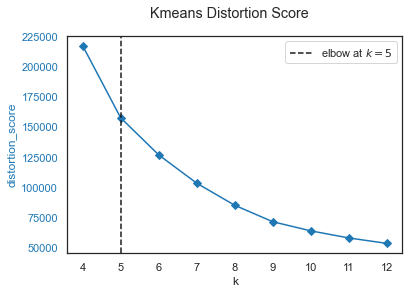

In [85]:

def plot_second_ax(df, x_col, y2_col, ax, color='grey'):
    """add a secondary y axis to a plot"""
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                 c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)


def plot_elbow(df, x_col, y_col, ax):
    """draw a vertical line at elbow on a plot"""
    elbow_k, elbow_score = find_elbow(df, x_col, y_col)
    elbow_label = f'elbow at ${x_col}={elbow_k}$'
    ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
    ax.legend(frameon=True)


def plot_vline(df, x_col, y_col, ax, line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k', score_col='distortion_score',
                          show_elbow=False, time_col=None, ax1=None):
    """
    Generic ElbowVisualiser, capable of showing any metric, elbows, secondary axis...
    Allows subsequent manipulation of plots
    """
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df, x_col, y2_col=time_col, ax=ax1)
    if show_elbow:
        plot_elbow(df, x_col, score_col, ax1)


# Test visualiser
plot_elbow_visualiser(scores, score_col='distortion_score',show_elbow=True)
plt.suptitle(f'Kmeans Distortion Score')
to_png()



### 4.3.2 Plot summary metrics
- visualiser plusieurs metriques com subplots

In [86]:
print(sorted(list(scores.columns)))


['ARI', 'calinski_harabasz', 'classifier', 'davies_bouldin', 'dimension_reduction', 'distortion_score', 'feature_extraction', 'fit_time_cluster', 'k', 'min_cluster_pct', 'silhouette_score']


"Plot_metrics_(feature_extraction_-_TfidfVectorizer;___dimension_reduction_TSNE).png"


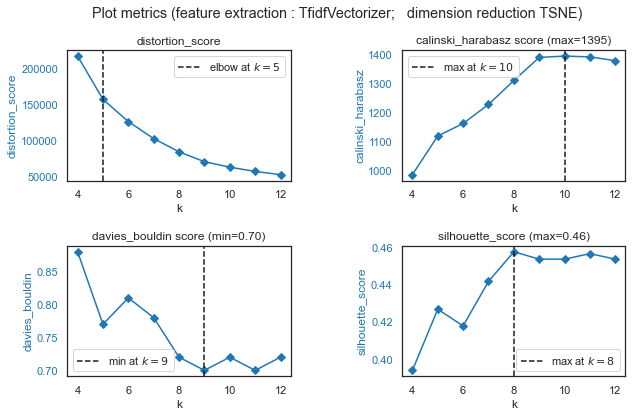

In [87]:

def plot_metrics(df_scores, x_col='k'):
    """
    Plot each clustering metric in df_scores in a subplot
    Plots to show depend on metrics added to df_scores
    Parameters
    ----------
    df_scores   Scores for all permutations of a param_grid (previously calculated)
    x_col       Choice of parameter to compare -by default k, but can show any hyperparameter
    """
    if 'clf' in df_scores.columns and 'preprocessor' in df_scores.columns:
        print(
            f"plotting metrics (clf: {df_scores['clf'][0]}, preprocessor: {df_scores['preprocessor'][0]})")

    METRICS = ['distortion_score', 'calinski_harabasz',
               'davies_bouldin', 'silhouette_score', 'stability_score']
    metrics = cols_in_df(df_scores, METRICS)
    n_plots = len(metrics)
    n_cols = min(n_plots, 2)
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots // n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric == 'distortion_score':
            plot_elbow_visualiser(
                df_scores, x_col, metric, ax1=ax, time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric == 'calinski_harabasz':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric == 'davies_bouldin':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric == 'silhouette_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='silhouette_score',
                             yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='silhouette_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)
        if metric == 'stability_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'stability_score_std' in df_scores.columns:
                if 'stability_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['stability_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='stability_score',
                             yerr='stability_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='stability_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.suptitle(f"Plot metrics (feature extraction : {df_scores['feature_extraction'][0]};   dimension reduction {df_scores['dimension_reduction'][0]})")

# test
plot_metrics(scores)
to_png()

## 4.4 Visualisation des clusters sur les 'reduced_dimensions'

8


<AxesSubplot:>

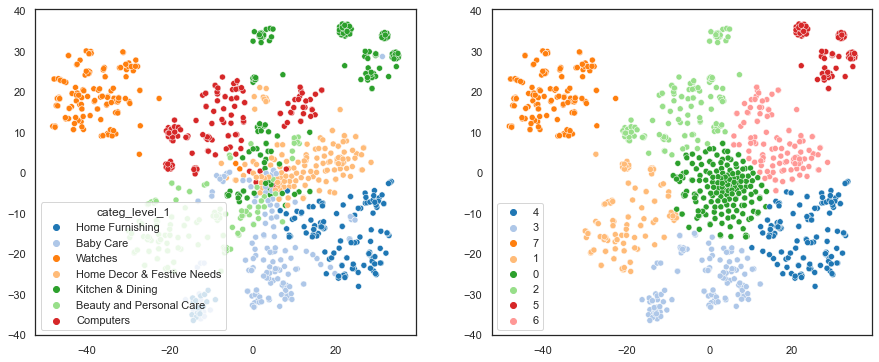

In [88]:
# scores, labels, red_dim = score_model(data_T)
print (pd.Series(labels).nunique())
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.scatterplot(ax=ax1,x=red_dim[:,0], y=red_dim[:,1], hue=pd.Series(y_cat_txt,dtype=str))
sns.scatterplot(ax=ax2,x=red_dim[:,0], y=red_dim[:,1], hue=pd.Series(labels,dtype=str))

### 4.4.1 Calcul de meilleur correspondance entre categorie et cluster label

Les cluster labels attribué par des modélisations (ex: kmeans) sont aléatoires, que fait que des comparaisons entre la catégorie atribuée et les libellés sont difficil a comparer : ils n'ont pas les même couleurs

On essaie de faire correspondre les cluster labels dans la même ordre que categ_true, 
    pour faciliter :
        - la matrice de confusion entre categorie et cluster
        - la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
        - les diagrammes Sankey pour montre les rélations 

- https://sparse-plex.readthedocs.io/en/latest/book/clustering/comparing_clusterings.html
- https://python.plainenglish.io/hungarian-algorithm-introduction-python-implementation-93e7c0890e15
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

Comme alternative à KMeans (algorithme publié octobre 2021):
- https://www.researchgate.net/publication/353696146_The_utility_of_clusters_and_a_Hungarian_clustering_algorithm

In [89]:
from scipy.optimize import linear_sum_assignment

def squarify_df(df:pd.DataFrame, val=0):
    rows,cols=df.shape
    if rows > cols:
        # append columns to end of dataframe
        pad_cols=rows-cols
        pad_df=pd.DataFrame(np.zeros((rows,pad_cols),dtype=int), index=df.index)
        pad_df.columns=[f'pad_{i}'for i in range(pad_cols)]
        df=df.join(pad_df)
    elif cols > rows:
        # append rows to end of dataframe
        pad_rows=cols-rows
        pad_df=pd.DataFrame(data=np.zeros((cols-rows,cols),dtype=int),
        columns=range(cols))
        pad_df.index=[f'pad_{i}'for i in range(pad_rows)]
        df=df.append(pad_df)
    return df

df_test_rows=pd.DataFrame([[1,0,6],[0,3,3]])
df_test_cols=df_test_rows.T
print(df_test_rows.shape)
print(squarify_df(df_test_rows))
print(squarify_df(df_test_cols))

(2, 3)
       0  1  2
0      1  0  6
1      0  3  3
pad_0  0  0  0
   0  1  pad_0
0  1  0      0
1  0  3      0
2  6  3      0


In [90]:
def conf_matrix_labels(categ_true, clust_labels, normalize=False):
    """
    Calcul de meilleur correspondance entre true_categorie et predicted categorie
    
    Les cluster labels attribué par kmeans sont aléatoires. 
    On essaie de mettre les cluster labels dans la même ordre que categ_true, 
    pour faciliter :
        - la matrice de confusion entre categorie et cluster
        - la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
        - les diagrammes Sankey pour montre les rélations 
    """
    
    # créer le crosstab entre categorie et cluster label
    df_matr:pd.DataFrame = pd.crosstab(categ_true, clust_labels,
                            normalize=normalize)
    
    # Si besoin, créer un matrice carré pour pouvoir applique l'algorithme
    n_categ = df_matr.shape[0]
    n_labels = df_matr.shape[1]
    
    square_matr=squarify_df(df_matr).fillna(0) 

    # trouve ordre de colonnes et lignes pour maximiser valeurs dans le diagonale
    rows, cols = linear_sum_assignment(square_matr.values, maximize=True)
     
    if len(rows) > n_categ:
        rows = [idx for idx in rows if idx < n_categ]
    if len(cols) > n_labels:
        cols = [idx for idx in cols if idx < n_labels]
    # print(f'len(rows) : {len(rows)}')
    # print(f'len(cols) : {len(cols)}')
    df_opt=df_matr.iloc[:,cols]


    new_cols=[str(col) for col in df_opt.index]
    cluster_labelmap= dict(zip(list(df_opt.columns), new_cols))

    if normalize == False:
        df_opt = df_opt.round(0).astype(int)

    return df_opt, cluster_labelmap

str_labels= pd.Series(labels).map(lambda x:f'cluster_{x}')
conf_matrix_labels(categ_true =y_cat_txt, clust_labels=pd.Series(labels,dtype=str))


(col_0                        3   1   2   6    4   5    7   0
 categ_level_1                                               
 Baby Care                   96   5   0   0   12   1    0  36
 Beauty and Personal Care    16  97   1   9    0   0    0  27
 Computers                    0  18  90  31    0   0    0  11
 Home Decor & Festive Needs   0   0   9  83    3   0    0  55
 Home Furnishing             19   0   0   0  116   0    0  15
 Kitchen & Dining             0   0  36   2    0  74    0  38
 Watches                      0   1   0   0    0   0  147   2,
 {'3': 'Baby Care',
  '1': 'Beauty and Personal Care',
  '2': 'Computers',
  '6': 'Home Decor & Festive Needs',
  '4': 'Home Furnishing',
  '5': 'Kitchen & Dining',
  '7': 'Watches'})

### 4.4.2 Clustering KMeans via TSNE, et calcul de metric ARI

Un fois les scores sont calculés, les procédures ci-dessous permet de visualiser


In [91]:
from sklearn import manifold
import time
from numpy import ndarray

def reducer_tsne(features:pd.Series)->ndarray:
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=RANDOM_SEED)
    X_tsne = tsne.fit_transform(features)
    time2 = np.round(time.time() - time1, 0)
    print(f'reducer t-SNE, shape ={X_tsne.shape} time : {time2}')
    return X_tsne



In [92]:
from sklearn import cluster, metrics
import time

def ARI_fct(features,categories_=l_cat, y_cat_num_=y_cat_num, k=None):
    """
    Calcul Tsne, détermination des clusters et calcul ARI 
    entre vrais catégorie et n° de clusters
    """
    X_tsne= reducer_tsne(features)
    
    if k is None or not k > 0:
        k= len(categories_)

    time1 = time.time()
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=k, n_init=100,
                         random_state=RANDOM_SEED)
    cls.fit(X_tsne)
    time2 = np.round(time.time() - time1, 0)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num_, cls.labels_), 4)

    print("ARI : ", ARI, "time : ", time2)
    # ajout cls.cluster_centers_ ?
    return ARI, X_tsne, cls.labels_




### 4.2.2 Visualisation des clusters sur les dimensions réduits


In [93]:

#
def TSNE_visu_fct(X_tsne_, y_cat_num_, labels_, ARI_, l_cat_=l_cat,
                  bbox_left=-0.05, loc=1,
                  palette='bright',
                  titre1='Représentation des produits par catégories réelles',
                  titre2='Représentation des produits par clusters'):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """

    df_opt, label_map=conf_matrix_labels(y_cat_num_, labels_)

    # s_labels=pd.Series(labels_).map(label_map)
    s_labels=pd.Series(labels_)

    # mettre l'ordre des clusters dans la même ordre que les y_cat
    labels_hue_order = list(df_opt.columns)
    n_labels=len(labels_hue_order)

    categ_hue_order=sorted(list(pd.Series(y_cat_num_).unique()))
    n_categ=len(categ_hue_order)

    n_max=max(n_labels,n_categ)
    colors=sns.color_palette(palette,n_colors=n_max)
    # print (colors)
    labels_palette= colors[:n_labels]
    categ_palette=colors[:n_categ]
    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121)
    scatter1 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1],ax=ax1, 
                          hue=y_cat_num_,hue_order=categ_hue_order, palette=categ_palette)
    ax1.legend(title="Categorie", bbox_to_anchor=(bbox_left, 0.5),loc=loc )
    plt.title(titre1)
    
    ax2 = fig.add_subplot(122)
    scatter2 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax2,
    hue=s_labels, hue_order=labels_hue_order,palette=labels_palette)
    ax2.legend(loc="best", title="Clusters")
    plt.title(titre2)
    print("ARI : ", ARI_)
    return fig


# 5. Bag-of-Words et TF-IDF


## 5.1 Essaie 1 : Bag of words (BOW)

#### Références


### Création du bag of words (CountVectorizer)

On veut trouver des mots caracteristiques de chaque groupe


In [94]:
from sklearn.feature_extraction.text import CountVectorizer

# mots present dans un maximum de 95% des produits, et minimum de 3 produits
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=3)

# On aplique au sentence crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feature])

cv_transform = cvect.transform(data_T[feature])
print(cv_transform.shape)


(1050, 1379)


la matrice `cv_transform` représent le bag-of-words crée par CountVectorizer:


In [95]:
def show_example_bow():
    print(data_T[feature][40])
    print(data_T[feature][42])
    print(data_T[feature][43])

    df_bow = pd.DataFrame.sparse.from_spmatrix(
        cv_transform,
        columns=cvect.get_feature_names_out(),
        index=data_T.index)
    return df_bow.loc[40:45, ['grey', 'blue', 'pyjama',
                       'boy', 'baby', 'girl', 'hair', 'cm', 'cloth']]


show_example_bow()


key mom kid baby girl printed green top pyjama set fabric cotton greenmom kid baby girl printed green top pyjama set girl pyjama setspecifications mom kid baby girl printed green top pyjama set detail pattern printed ideal baby girl night suit detail fabric cotton top pyjama set neck round neck top pyjama set
key mom kid baby girl printed blue grey top pyjama set fabric cotton blue greymom kid baby girl printed blue grey top pyjama set girl pyjamasetspecifications mom kid baby girl printed blue grey top pyjama set detail pattern printed ideal baby girl night suit detail content fabric cotton top pyjama set neck round nack top pyjama set
key burt bee hair repair shea grapefruit deep conditioner ideal boy girl applied deep conditioning hair condition damaged hair hair dry hairspecifications burt bee hair repair shea grapefruit deep conditioner ml conditioner trait hair condition damaged hair hair dry hair applied deep conditioning ideal boy girl trait burt bee quantity ml model name hair

,grey,blue,pyjama,boy,baby,girl,hair,cm,cloth
40,0,0,6,0,4,5,0,0,0
41,2,0,0,0,0,0,0,5,0
42,3,4,5,0,4,5,0,0,0
43,0,0,0,2,0,2,10,0,0
44,0,0,0,0,0,0,0,2,1
45,0,0,0,0,0,0,0,2,1


### Calcul des clusters et affichage


### Uni-grammes

Extract_features (CountVectorizer), fit time = 0.06 s
Reduce dimensions (TSNE), fit time = 20.46 s
k=4, fit: 0.17 s, silhouette= 0.435, ARI = 0.27, cluster sizes = [32 31 20 16]
k=5, fit: 0.21 s, silhouette= 0.465, ARI = 0.312, cluster sizes = [27 25 20 14 11]
k=6, fit: 0.25 s, silhouette= 0.453, ARI = 0.344, cluster sizes = [28 18 16 14 14  8]
k=7, fit: 0.24 s, silhouette= 0.448, ARI = 0.392, cluster sizes = [20 15 14 14 13 13  8]
k=8, fit: 0.28 s, silhouette= 0.454, ARI = 0.428, cluster sizes = [17 14 14 13 11 11 10  8]
k=9, fit: 0.37 s, silhouette= 0.467, ARI = 0.462, cluster sizes = [17 14 13 13 12  9  8  7  4]
k=10, fit: 0.33 s, silhouette= 0.47, ARI = 0.455, cluster sizes = [14 13 13 12  9  9  8  7  7  4]
k=11, fit: 0.31 s, silhouette= 0.465, ARI = 0.453, cluster sizes = [14 13 12  9  9  8  7  7  7  6  4]
k=12, fit: 0.35 s, silhouette= 0.468, ARI = 0.438, cluster sizes = [14 12 11 11  9  8  7  6  6  5  4  2]


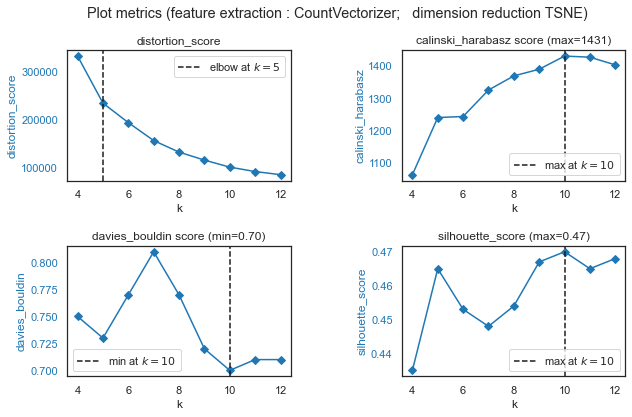

In [96]:
scores1, labels1, X_tsne1 = score_model(data_T, labels_true=y_cat_txt,
                                       feature_extractor=CountVectorizer(
                                           stop_words='english', ngram_range=(1, 1), max_df=0.95, min_df=3),
                                       dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                       init='random', learning_rate='auto'),
                                       kmin=4, kmax=12)
plot_metrics(scores1)

### Bi-grammes

Extract_features (CountVectorizer), fit time = 0.1 s
Reduce dimensions (TSNE), fit time = 19.26 s
k=4, fit: 0.23 s, silhouette= 0.356, ARI = 0.136, cluster sizes = [36 25 18 18]
k=5, fit: 0.21 s, silhouette= 0.391, ARI = 0.252, cluster sizes = [33 19 17 16 13]
k=6, fit: 0.39 s, silhouette= 0.399, ARI = 0.265, cluster sizes = [31 16 14 14 11 11]
k=7, fit: 0.34 s, silhouette= 0.401, ARI = 0.327, cluster sizes = [24 16 13 11 11 11 10]
k=8, fit: 0.38 s, silhouette= 0.409, ARI = 0.346, cluster sizes = [23 15 13 11 10 10  8  7]
k=9, fit: 0.3 s, silhouette= 0.413, ARI = 0.35, cluster sizes = [23 13 11 10 10  9  8  8  3]
k=10, fit: 0.34 s, silhouette= 0.405, ARI = 0.315, cluster sizes = [19 11 11 10  9  9  9  8  8  3]
k=11, fit: 0.31 s, silhouette= 0.414, ARI = 0.326, cluster sizes = [18 12 11 10  9  9  8  8  7  3  1]
k=12, fit: 0.37 s, silhouette= 0.415, ARI = 0.328, cluster sizes = [17 12 10  9  9  9  8  8  7  4  1  0]


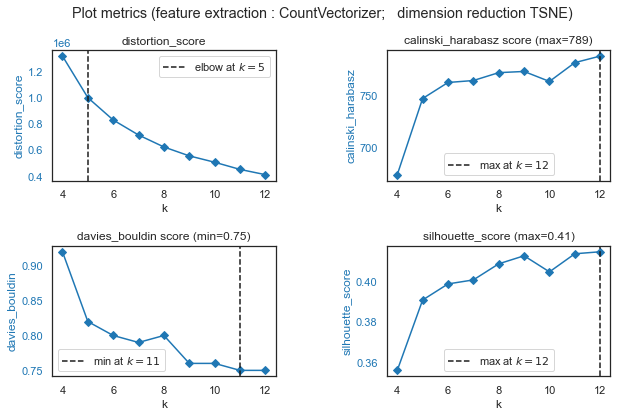

In [97]:
scores1_bigrammes, labels1, X_tsne1 = score_model(data_T, labels_true=y_cat_txt,
                                       feature_extractor=CountVectorizer(
                                           stop_words='english', ngram_range=(2, 2), max_df=0.95, min_df=3),
                                       dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                       init='random', learning_rate='auto'),
                                       kmin=4, kmax=12)
plot_metrics(scores1_bigrammes)

### Tri-grammes

Extract_features (CountVectorizer), fit time = 0.08 s
Reduce dimensions (TSNE), fit time = 21.6 s
k=4, fit: 0.19 s, silhouette= 0.347, ARI = 0.125, cluster sizes = [36 24 20 18]
k=5, fit: 0.18 s, silhouette= 0.368, ARI = 0.08, cluster sizes = [29 18 18 16 16]
k=6, fit: 0.25 s, silhouette= 0.39, ARI = 0.141, cluster sizes = [29 14 14 13 13 13]
k=7, fit: 0.25 s, silhouette= 0.385, ARI = 0.127, cluster sizes = [29 13 13 12 10 10 10]
k=8, fit: 0.24 s, silhouette= 0.379, ARI = 0.134, cluster sizes = [29 11 10 10  9  9  9  8]
k=9, fit: 0.27 s, silhouette= 0.357, ARI = 0.102, cluster sizes = [22 13 10  9  9  9  8  8  7]
k=10, fit: 0.29 s, silhouette= 0.358, ARI = 0.112, cluster sizes = [22 12  9  8  8  8  8  7  7  6]
k=11, fit: 0.46 s, silhouette= 0.361, ARI = 0.107, cluster sizes = [19 11  9  9  8  8  7  7  6  6  6]
k=12, fit: 0.39 s, silhouette= 0.363, ARI = 0.11, cluster sizes = [18  9  9  8  8  7  7  6  6  6  5  5]


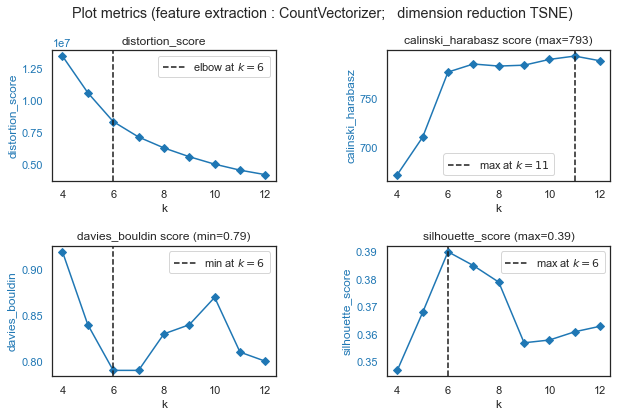

In [98]:
scores1_trigrammes, labels1, X_tsne1 = score_model(data_T, labels_true=y_cat_txt,
                                       feature_extractor=CountVectorizer(
                                           stop_words='english', ngram_range=(3, 3), max_df=0.95, min_df=3),
                                       dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                       init='random', learning_rate='auto'),
                                       kmin=4, kmax=12)
plot_metrics(scores1_trigrammes)

Silhouette Visualisation des meilleurs clusters

"Silhouette_score_for_7_clusters_-_0-389-Features_=_foo.png"


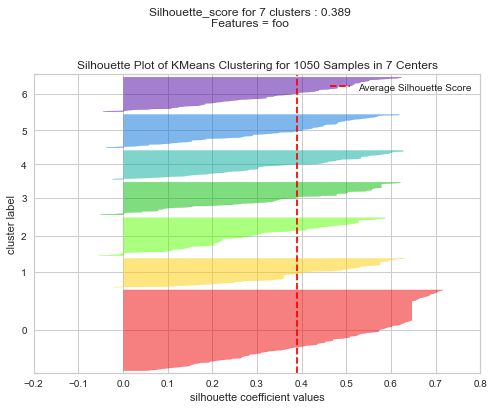

In [99]:
from yellowbrick.cluster import SilhouetteVisualizer


def plot_silhouettes(df: pd.DataFrame, k_clusters=7):
    """shortcut to preprocess, fit and run silhouette visualizer"""
    cluster_colors = sns.color_palette('nipy_spectral_r', n_colors=k_clusters)
    estimator = KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED)
    visualizer= SilhouetteVisualizer(estimator, colors=cluster_colors)
    visualizer.fit(df)
    # ~ 5 minutes
    visualizer.finalize()        # Finalize and render the figure
    titre = f'Silhouette_score for {k_clusters} clusters : {visualizer.silhouette_score_:.3f}'
    subtitre = f'Features = foo'
    plt.suptitle(f'{titre}\n{subtitre}', fontsize=12, y=1.05)
    to_png(f'{titre}-{subtitre}')


plot_silhouettes(X_tsne1, k_clusters=7)

### Visualise les meilleur résultats

In [100]:
print("CountVectorizer : ")
print("-----------------")
ARI1, X_tsne1, labels1 = ARI_fct(cv_transform, k=7)
# Ajout au résultat
data_T['labels_bow'] = labels1


CountVectorizer : 
-----------------
reducer t-SNE, shape =(1050, 2) time : 20.0
ARI :  0.4076 time :  2.0


ARI :  0.4076
"Bag-of-Words_(CountVectorizer),_ARI_=_0-408.png"


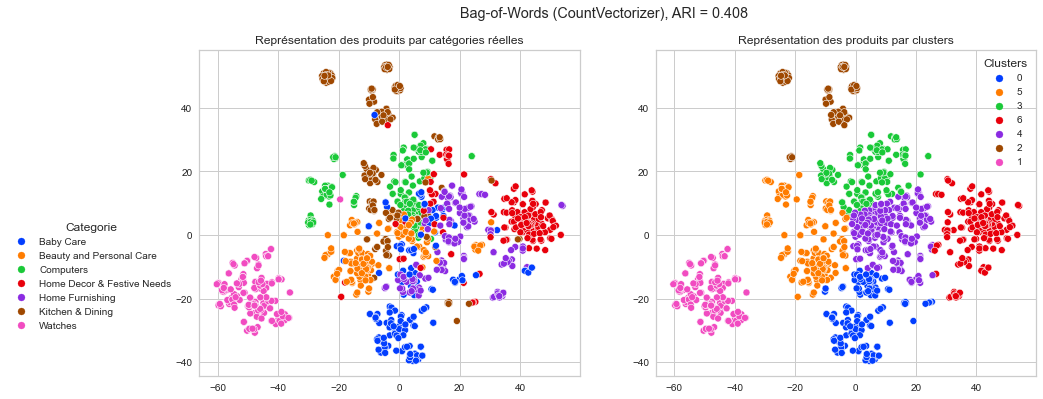

In [101]:
fig = TSNE_visu_fct(X_tsne1, y_cat_txt, labels1, ARI1, palette='bright')
plt.suptitle(f'Bag-of-Words (CountVectorizer), ARI = {ARI1:.3f}')
to_png()


### Comparaison si on ne retire pas les publicités


CountVectorizer (avec ads): 
-----------------
reducer t-SNE, shape =(1050, 2) time : 20.0
ARI :  0.4427 time :  2.0
ARI :  0.4427
"Bag-of-Words_avec_Ads_(CountVectorizer),_ARI_=_0-443.png"


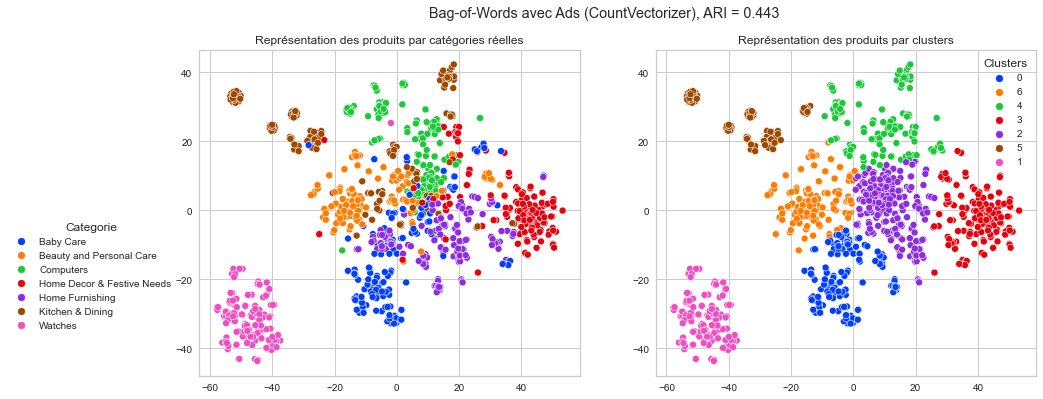

In [102]:
# On aplique au sentence crée à partir de bag-of-words avec lemmatization
feature_ads = 'sentence_bow_lem_ads'
cv_fit = cvect.fit(data_T[feature_ads])

cv_transform2 = cvect.transform(data_T[feature_ads])
print("CountVectorizer (avec ads): ")
print("-----------------")
ARI1a, X_tsne1a, labels1a = ARI_fct(cv_transform2)
fig = TSNE_visu_fct(X_tsne1a, y_cat_txt, labels1a, ARI1a)
plt.suptitle(f'Bag-of-Words avec Ads (CountVectorizer), ARI = {ARI1a:.3f}')
to_png()

En effet, les publicités de flipkart crée des markers de catégorie, car seulement certains catégories contient ces publicités

On reste sur les descriptions sans publicité,

In [103]:
del cv_transform2

## 5.2 Essaie 2 : TF-IDF

(Term Frequency - Inverse Document Frequency)

### Création du matrice de mots (Tf-idf)

On fait comme pour le Bag-of-Words


In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

# mots present dans un maximum de 95% des produits, et minimum de 3 produits
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)

# On aplique au sentence crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
ctf_fit = ctf.fit(data_T[feature])
ctf_transform = ctf.transform(data_T[feature])


la matrice `ctf_transform` représent les vectors TF-IDF crée par TfidfVectorizer:


In [105]:
df_tf = pd.DataFrame.sparse.from_spmatrix(
    ctf_transform,
    columns=ctf.get_feature_names_out(),
    index=data_T.index)


print(data_T[feature][40])
print(data_T[feature][42])
print(data_T[feature][43])

df_tf.loc[40:45, ['grey', 'blue', 'pyjama',
                  'boy', 'baby', 'girl', 'hair', 'cm', 'cloth']]


key mom kid baby girl printed green top pyjama set fabric cotton greenmom kid baby girl printed green top pyjama set girl pyjama setspecifications mom kid baby girl printed green top pyjama set detail pattern printed ideal baby girl night suit detail fabric cotton top pyjama set neck round neck top pyjama set
key mom kid baby girl printed blue grey top pyjama set fabric cotton blue greymom kid baby girl printed blue grey top pyjama set girl pyjamasetspecifications mom kid baby girl printed blue grey top pyjama set detail pattern printed ideal baby girl night suit detail content fabric cotton top pyjama set neck round nack top pyjama set
key burt bee hair repair shea grapefruit deep conditioner ideal boy girl applied deep conditioning hair condition damaged hair hair dry hairspecifications burt bee hair repair shea grapefruit deep conditioner ml conditioner trait hair condition damaged hair hair dry hair applied deep conditioning ideal boy girl trait burt bee quantity ml model name hair

,grey,blue,pyjama,boy,baby,girl,hair,cm,cloth
40,0.00,0.00,0.66,0.00,0.25,0.31,0.00,0.00,0.00
41,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00
42,0.29,0.29,0.56,0.00,0.26,0.32,0.00,0.00,0.00
43,0.00,0.00,0.00,0.09,0.00,0.09,0.71,0.00,0.00
44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.07
45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.07


### Exécution du modèle (clustering) et visualisation


In [106]:
print("Tf-idf : ")
print("--------")
ARI2, X_tsne2, labels2 = ARI_fct(ctf_transform)
# Ajout au résultat
data_T['labels_tfidf'] = labels2


Tf-idf : 
--------
reducer t-SNE, shape =(1050, 2) time : 16.0
ARI :  0.4193 time :  2.0


ARI :  0.4193
"Bag-of-Words_(TF-IDF),_ARI_=_0-419.png"


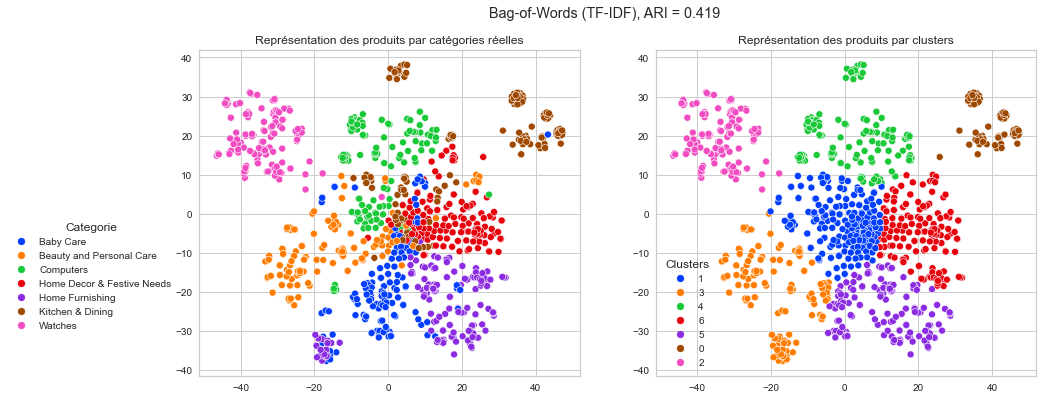

In [107]:
fig = TSNE_visu_fct(X_tsne2, y_cat_txt, labels2, ARI2)
plt.suptitle(f'Bag-of-Words (TF-IDF), ARI = {ARI2:.3f}')
to_png()


# 6. LDA - (Topic modelling)

## 6.1 Essaie 3 : LDA - Latent Dirichlet Allocation

On va essaie de trouver les topics (clusters)

- à partir de Bag-Of-Words
- à partir de TF-IDF

Features à créer:

- `topic_LDA_BOW` : catégories crées à partir des 'Bag-of-Words' descriptions
- `topic_LDA_TF` : catégories crées à partir des 'TF-IDF' matrice


### Grid search pour méilleur paramètres


In [108]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
NB_TOPICS = 7
# RANDOM_SEED = 0
# Define Search Param
# 40s per search

lda = LDA(
    n_components=NB_TOPICS,
    max_iter=10,
    learning_method='online',
    random_state=RANDOM_SEED,
)


### 6.3.1 Essaie 3a : LDA sur Bag-of-Words


In [109]:
# Cette param_grid prend environ 5 minutes
# decommentarise pour tester
# param_grid = {'learning_method':['batch','online'],
param_grid = {'n_components':range(6,11),
'learning_method':['online'],
                # 'learning_decay': [0.5,0.7, 0.9, 0.95],
                'learning_decay': [ 0.9],
                # 'learning_offset':[2, 5, 10, 20, 50, 100],
                'learning_offset':[ 20],
                }
# # best params
# param_grid = {'learning_method': ['online'],
#               'learning_decay': [0.5], 'learning_offset': [2]}
# param_grid={'learning_decay': [0.9], 'learning_method': ['online'], 'learning_offset': [20]}
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=param_grid,verbose=2,cv=2)

# Do the Grid Search
model.fit(cv_transform)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=6; total time=   1.3s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=6; total time=   1.0s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=7; total time=   1.2s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=7; total time=   1.0s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=8; total time=   1.1s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=8; total time=   1.0s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=9; total time=   1.0s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_components=9; total time=   1.2s
[CV] END learning_decay=0.9, learning_method=online, learning_offset=20, n_c

GridSearchCV(cv=2,
             estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_components=7,
                                                 random_state=42),
             param_grid={'learning_decay': [0.9], 'learning_method': ['online'],
                         'learning_offset': [20],
                         'n_components': range(6, 11)},
             verbose=2)

In [110]:
print(model.best_params_)
# Create Document - Topic Matrix
lda_output = model.best_estimator_.transform(cv_transform)
n_topics=lda_output.shape[1]
# column names
topics = [f'Topic {i}' for i in range(0, n_topics)]
# Make the pandas dataframe
df_topics = pd.DataFrame(np.round(lda_output, 2),
                         columns=topics, index=data_T.index)
# Get dominant topic for each document
df_topics['pred_topic'] = np.argmax(df_topics.values, axis=1)
df_topics.head()


{'learning_decay': 0.9, 'learning_method': 'online', 'learning_offset': 20, 'n_components': 7}


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,pred_topic
0,0.00,0.09,0.06,0.55,0.00,0.00,0.30,3
1,0.07,0.00,0.00,0.38,0.00,0.00,0.54,6
2,0.05,0.00,0.00,0.21,0.03,0.02,0.69,6
3,0.32,0.00,0.00,0.14,0.00,0.00,0.53,6
4,0.34,0.00,0.00,0.08,0.00,0.00,0.58,6


In [111]:

df_data_topics = data_T.join(df_topics)
df_data_topics['pred_topic'].value_counts()


6    260
0    254
3    136
1    135
5    104
2     82
4     79
Name: pred_topic, dtype: int64

#### Comparaison de predicted topic et catégorie level 1


In [112]:
# pd.crosstab(df_data_topics['categ_level_1'],
#             df_data_topics['pred_topic'])
res, labels=conf_matrix_labels(df_data_topics['categ_level_1'],df_topics['pred_topic'])
res.style.background_gradient(axis=1)

pred_topic,3,5,4,6,1,2,0
categ_level_1,,,,,,,
Baby Care,100,2,1,32,7,1,7
Beauty and Personal Care,2,21,3,23,14,0,87
Computers,0,61,73,1,8,0,7
Home Decor & Festive Needs,0,8,0,135,7,0,0
Home Furnishing,34,0,0,58,55,0,3
Kitchen & Dining,0,12,2,10,42,81,3
Watches,0,0,0,1,2,0,147


In [113]:
from sklearn import metrics
ARI3a = metrics.adjusted_rand_score(
    df_data_topics['categ_level_1'], df_data_topics['pred_topic'])
print(ARI3a)
data_T['labels_LDA1'] = df_data_topics['pred_topic']


0.38738547450923183


ARI :  0.38738547450923183
"LDA_sur_Bag-of-Words,_ARI_=_0-387.png"


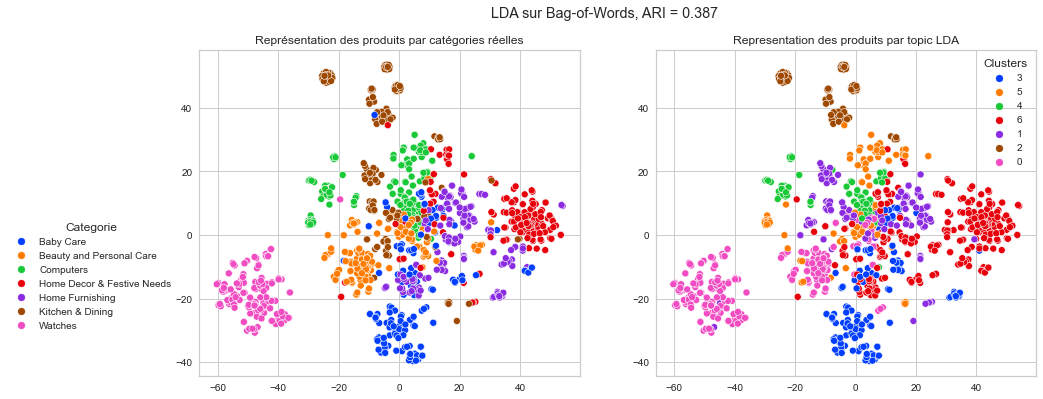

In [114]:
fig = TSNE_visu_fct(X_tsne1, y_cat_txt,
                    data_T['labels_LDA1'], ARI3a)
fig.axes[1].set_title('Representation des produits par topic LDA')
plt.suptitle(f'LDA sur Bag-of-Words, ARI = {ARI3a:.3f}')
to_png()


In [115]:
def get_topic_words(model, words, nb_words=10):
    
    for idx, topic in enumerate(model.components_):
        text = ",".join([words[i] for i in topic.argsort()[:nb_words]])
        print(f'Topic {idx+1}: {text}')


get_topic_words(model.best_estimator_, ctf.get_feature_names_out())


Topic 1: carrying,sound,statue,diameter,comforting,exfoliating,cospecifications,magsafe,tribal,adapter
Topic 2: quote,enjoyment,thnkss,cushion,guided,deviation,forever,wonderful,hood,carpet
Topic 3: massage,rectangular,pen,ghz,god,pyjama,ordering,vitamin,phone,aline
Topic 4: wifi,portronics,extract,hp,assure,techone,organic,date,limited,adhesive
Topic 5: placed,religious,loop,printland,rockmantra,catchy,buddha,perucci,kit,freedom
Topic 6: vincent,polish,placed,sleepsuit,comforter,vibrant,night,embroidery,art,domestic
Topic 7: crash,open,compatible,cupcake,ram,sony,palito,assured,hmt,archies


In [116]:
def get_topic_words_from_data(df=data_T, feature='sentence_bow_lem', topic_col='labels_LDA1', nb_words=10):
    topic_labels = df[topic_col].unique()
    for topic in sorted(topic_labels):
        topic_data = df[df[topic_col] == topic]
        freq_words = get_corpus_freq(topic_data[feature], nb=nb_words)
        text = freq_words.index.tolist()
        # text = ",".join(freq_words)
        print(f'Topic {topic}: {text}')


get_topic_words_from_data(
    data_T, feature='sentence_bow_lem', topic_col='labels_LDA1', nb_words=10)


unique words: 817
Topic 0: ['watch', 'analog', 'men', 'woman', 'set', 'combo', 'dial', 'strap', 'boy', 'water']
unique words: 1174
Topic 1: ['quality', 'pizza', 'steel', 'single', 'blanket', 'kadhai', 'l', 'quilt', 'cutter', 'high']
unique words: 403
Topic 2: ['mug', 'ceramic', 'perfect', 'coffee', 'gift', 'one', 'design', 'material', 'loved', 'give']
unique words: 1109
Topic 3: ['baby', 'girl', 'detail', 'cotton', 'fabric', 'dress', 'boy', 'ideal', 'sleeve', 'pattern']
unique words: 833
Topic 4: ['warranty', 'adapter', 'battery', 'laptop', 'product', 'quality', 'power', 'vaio', 'charger', 'please']
unique words: 1181
Topic 5: ['usb', 'skin', 'laptop', 'light', 'shape', 'bottle', 'led', 'inch', 'set', 'multicolor']
unique words: 2334
Topic 6: ['cm', 'showpiece', 'inch', 'cover', 'material', 'width', 'home', 'cotton', 'towel', 'dimension']


[3 6 0 1 5 2 4]


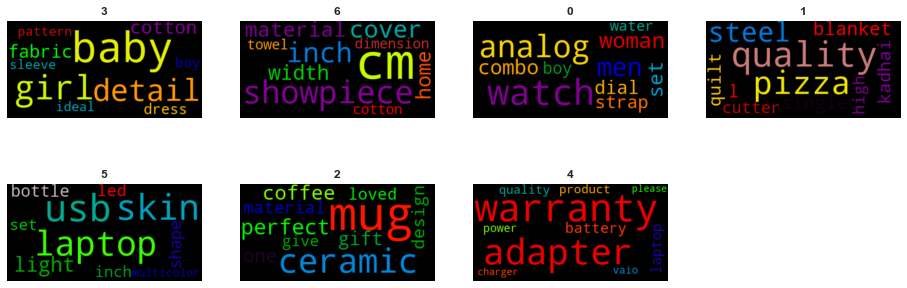

In [117]:
plot_wordclouds_by_categ(data_T, feature='sentence_bow_lem', categ_col='labels_LDA1', nb=10)

### 6.3.2 Essaie 3b : LDA sur TF-IDF


In [118]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
NB_TOPICS = 7
# RANDOM_SEED = 0
# Define Search Param
# 40s per search

lda = LDA(
    n_components=NB_TOPICS,
    max_iter=20,
    learning_method='online',
    random_state=RANDOM_SEED,
)

# Cette param_grid prend environ 5 minutes
# decommentarise pour tester
# param_grid = {'learning_method':['batch','online'],
#                 'learning_decay': [0.5,0.7, 0.9],
#                 'learning_offset':[2, 5, 10, 20],
#                 }
param_grid = {'learning_method':['online'],
                'learning_decay': [ 0.9, 0.95],
                # 'learning_decay': [ 0.9, 0.95],
                # 'learning_offset':[2, 5, 10, 20, 50, 100],
                'learning_offset':[ 50, 100],
                }
# best params
# param_grid = {},
model = GridSearchCV(lda, param_grid=param_grid)
model.fit(ctf_transform)
print(model.best_params_)


{'learning_decay': 0.9, 'learning_method': 'online', 'learning_offset': 50}


In [119]:

lda_output = model.best_estimator_.transform(ctf_transform)

# column names
topics = [f'Topic {i}' for i in range(0, NB_TOPICS)]
df_topics = pd.DataFrame(np.round(lda_output, 2),
                         columns=topics, index=data_T.index)
# Get dominant topic for each document
df_topics['pred_topic'] = np.argmax(df_topics.values, axis=1)+1
print(df_topics.head())

df_data_topics = data_T.join(df_topics)
df_data_topics['pred_topic'].value_counts()


   Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  pred_topic
0     0.02     0.02     0.02     0.02     0.02     0.02     0.87           7
1     0.10     0.03     0.03     0.03     0.03     0.03     0.75           7
2     0.23     0.02     0.02     0.02     0.02     0.02     0.65           7
3     0.02     0.02     0.02     0.02     0.02     0.02     0.85           7
4     0.02     0.02     0.02     0.02     0.02     0.02     0.87           7


1    462
7    395
3     53
6     49
2     44
5     39
4      8
Name: pred_topic, dtype: int64

In [120]:
pd.crosstab(df_data_topics['categ_level_1'],
            df_data_topics['pred_topic']).style.background_gradient(axis=1)


pred_topic,1,2,3,4,5,6,7
categ_level_1,,,,,,,
Baby Care,107,1,0,1,1,0,40
Beauty and Personal Care,100,16,0,3,0,11,20
Computers,58,4,16,3,28,38,3
Home Decor & Festive Needs,0,3,4,0,0,0,143
Home Furnishing,10,20,0,0,0,0,120
Kitchen & Dining,37,0,33,1,10,0,69
Watches,150,0,0,0,0,0,0


In [121]:
from sklearn import metrics
ARI3b = metrics.adjusted_rand_score(
    df_data_topics['categ_level_1'], df_data_topics['pred_topic'])
print(ARI3b)
data_T['labels_LDA2'] = df_data_topics['pred_topic']


0.18896813430565432


ARI :  0.18896813430565432
"LDA_sur_TF-IDF,_ARI_=_0-189.png"


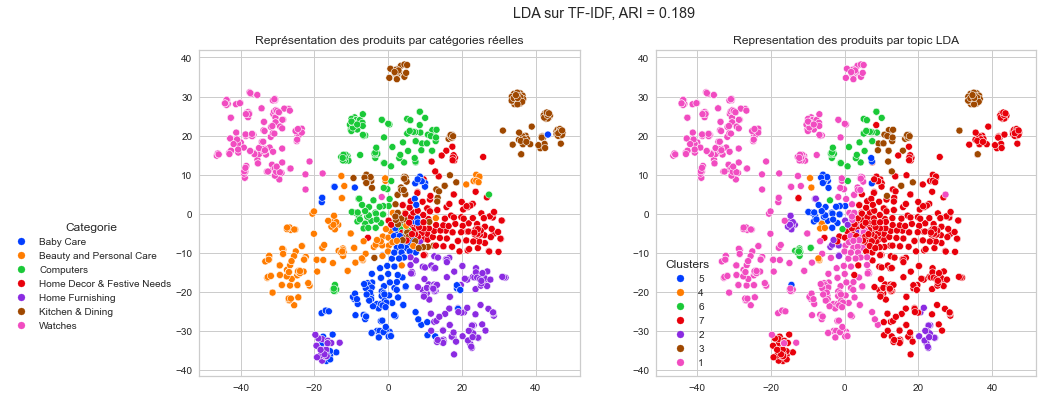

In [122]:
fig = TSNE_visu_fct(X_tsne2, y_cat_txt,
                    data_T['labels_LDA2'], ARI3b)
fig.axes[1].set_title('Representation des produits par topic LDA')
plt.suptitle(f'LDA sur TF-IDF, ARI = {ARI3b:.3f}')
to_png()

In [123]:

get_topic_words(model.best_estimator_, ctf.get_feature_names_out())


Topic 1: carrying,sound,statue,sized,comforting,exfoliating,cospecifications,magsafe,tribal,rrp
Topic 2: cushion,thing,ranging,thnkss,help,control,assembly,quote,guided,enjoyment
Topic 3: wild,massage,rectangular,pen,ghz,god,pyjama,ordering,vitamin,holiday
Topic 4: wifi,child,glovespecifications,creation,away,portronics,logo,extract,left,ball
Topic 5: placed,strip,religious,loop,printland,rockmantra,colored,suitablefor,month,interface
Topic 6: vincent,low,polish,placed,craft,relative,sleepsuit,wish,vibrant,night
Topic 7: cutter,fan,vincent,nutcase,open,sony,cap,palito,adidas,assured


In [124]:
get_topic_words_from_data(
    data_T, feature='sentence_bow_lem', topic_col='labels_LDA2', nb_words=20)


unique words: 2411
Topic 1: ['watch', 'baby', 'analog', 'girl', 'set', 'detail', 'boy', 'men', 'cotton', 'fabric', 'laptop', 'skin', 'combo', 'woman', 'ideal', 'battery', 'dress', 'warranty', 'water', 'content']
unique words: 255
Topic 2: ['hair', 'conditioner', 'comforter', 'quilt', 'brush', 'trait', 'single', 'spf', 'ml', 'ideal', 'abstract', 'floral', 'double', 'multicolor', 'applied', 'pa', 'condition', 'rajasthan', 'quantity', 'sunscreen']
unique words: 377
Topic 3: ['light', 'ceramic', 'mug', 'rockmantra', 'led', 'material', 'size', 'perfect', 'design', 'usb', 'one', 'dishwasher', 'gift', 'safe', 'come', 'product', 'x', 'detail', 'exclusive', 'year']
unique words: 89
Topic 4: ['lip', 'peppermint', 'balm', 'g', 'resistant', 'grip', 'soyeux', 'pencil', 'asus', 'pepper', 'basestrong', 'silk', 'scratch', 'armani', 'italian', 'chemical', 'handle', 'trainer', 'natural', 'way']
unique words: 244
Topic 5: ['pizza', 'cutter', 'steel', 'router', 'stainless', 'wireless', 'wheel', 'slice', '

# 7. Word2Vec

## 7.1 Essaie 4 : Word2Vec sur phrases lemmatizes


In [125]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics

from tensorflow.keras.models import Model
# for Word2Vec
import gensim


### Création du modèle Word2Vec


In [126]:
# longueur des phrases
_= calc_length_bow(data_T)


max length bow : 336
max length dl : 560


In [127]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 40  # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]


In [128]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")


Build & train Word2Vec model ...
Vocabulary size: 4930
Word2Vec trained


### Préparation des sentences (tokenization)


In [129]:
from tensorflow.keras.preprocessing.text import Tokenizer

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)


Fit Tokenizer ...
Number of unique words: 4931


## Création de la matrice d'embedding


In [130]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))


Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4931, 300)


## Création du modèle d'embedding


In [131]:
# Création du modèle
from tensorflow.keras import layers as klayers

input = klayers.Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = klayers.Input(shape=(maxlen,), dtype='float64')
word_embedding = klayers.Embedding(input_dim=vocab_size,
                                   output_dim=w2v_size,
                                   weights=[embedding_matrix],
                                   input_length=maxlen)(word_input)
word_vec = klayers.GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           1479300   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,479,300
Trainable params: 1,479,300
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle


In [132]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape


(1050, 300)

In [133]:
ARI4, X_tsne4, labels4 = ARI_fct(embeddings)
data_T['labels_W2V'] = labels4


reducer t-SNE, shape =(1050, 2) time : 19.0
ARI :  0.5415 time :  2.0


ARI :  0.5415
"Word2Vec,_ARI_=_0-541.png"


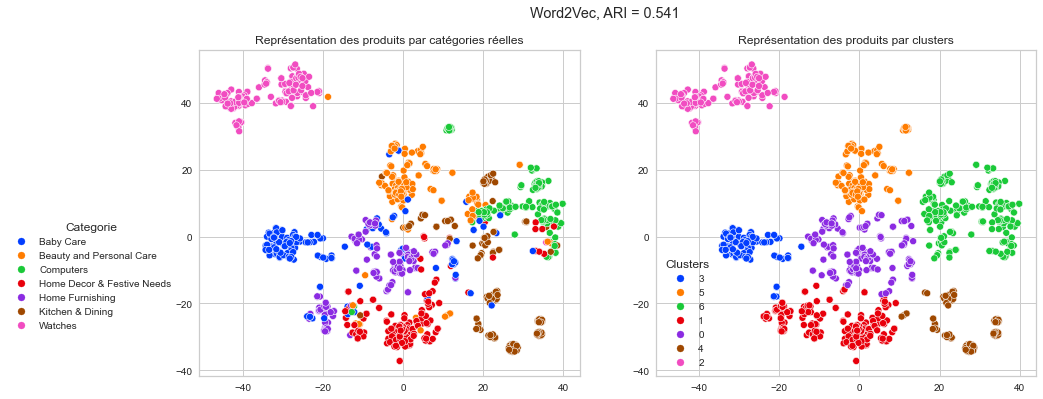

In [134]:
fig = TSNE_visu_fct(X_tsne4, y_cat_txt, labels4, ARI4)
plt.suptitle(f'Word2Vec, ARI = {ARI4:.3f}')
to_png()


# 7. BERT


In [135]:
import transformers
from transformers import TFBertModel, AutoTokenizer, TFAutoModel
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
print(tensorflow.keras.__version__)

# Bert
# from transformers import *

os.environ["TF_KERAS"] = '1'


2.8.0


In [136]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())


2.8.0
2.8.0
Num GPUs Available:  0
True


## 7.1 BERT - Fonctions communes


In [140]:
import time
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot


## 7.2 Essaie 5 : BERT HuggingFace


### 'bert-base-uncased'

- Downloads 511 Mb pretrained model


In [141]:
from transformers import TFAutoModel
model = TFAutoModel.from_pretrained('bert-base-uncased')

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

In [142]:
# Création des features
# downloads bert features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')


temps traitement :  120.0


In [143]:
ARI5, X_tsne5, labels5 = ARI_fct(features_bert)
data_T['labels_berthf'] = labels5


reducer t-SNE, shape =(1050, 2) time : 15.0
ARI :  0.389 time :  2.0


ARI :  0.389
"BERT_HuggingFace,_ARI_=_0-389.png"


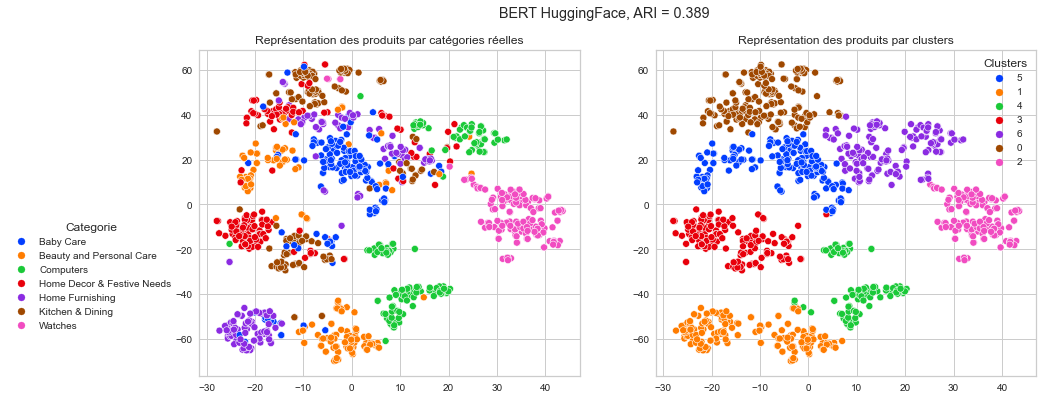

In [144]:
TSNE_visu_fct(X_tsne5, y_cat_txt, labels5, ARI5)
plt.suptitle(f'BERT HuggingFace, ARI = {ARI5:.3f}')
to_png()


## 7.3 Essaie 6 : BERT hub Tensorflow


In [145]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
small_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)


In [146]:
sentences = data_T['sentence_dl'].to_list()


In [147]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')


temps traitement :  147.0


In [148]:
ARI6, X_tsne6, labels6 = ARI_fct(features_bert)
data_T['labels_berthub'] = labels6


reducer t-SNE, shape =(1050, 2) time : 19.0
ARI :  0.3586 time :  2.0


ARI :  0.3586
BERT model_url : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
"BERT_Hub_(base_uncased),_ARI_=_0-359.png"


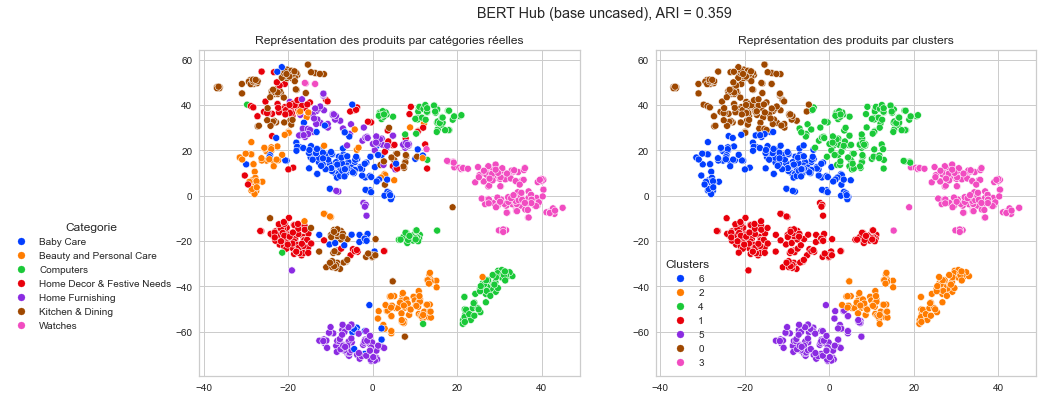

In [149]:
TSNE_visu_fct(X_tsne6, y_cat_txt, labels6, ARI6)
print(f'BERT model_url : {model_url}')
plt.suptitle(f'BERT Hub (base uncased), ARI = {ARI6:.3f}')

to_png()


# 8. USE - Universal Sentence Encoder

## 8. Essaie 7 : USE - Universal Sentence Encoder


In [150]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"] = '1'


In [151]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())


2.8.0
2.8.0
Num GPUs Available:  0
True


In [152]:
import tensorflow_hub as hub
USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_model_url)


In [153]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print(f'feature_USE_fct, time_taken = {time2} s')
    return features


In [154]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()


In [155]:
features_USE = feature_USE_fct(sentences, batch_size)


feature_USE_fct, time_taken = 1.0 s


In [156]:
ARI7, X_tsne7, labels7 = ARI_fct(features_USE)
data_T['labels_USE'] = labels7


reducer t-SNE, shape =(1050, 2) time : 17.0
ARI :  0.4627 time :  2.0


ARI :  0.4627
USE model_url : https://tfhub.dev/google/universal-sentence-encoder/4
"USE_-_Universal_Sentence_Encoder,_ARI_=_0-463.png"


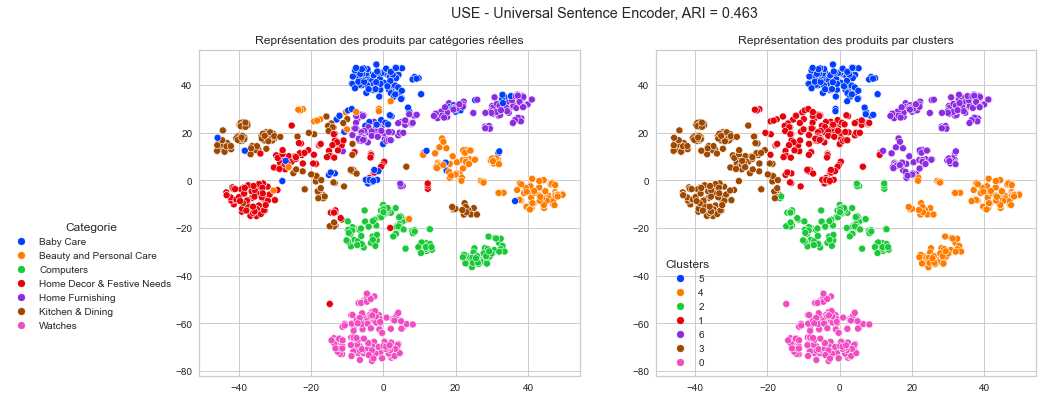

In [157]:
TSNE_visu_fct(X_tsne7, y_cat_txt, labels7, ARI7)

USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
print(f'USE model_url : {USE_model_url}')
plt.suptitle(f'USE - Universal Sentence Encoder, ARI = {ARI7:.3f}')
to_png()


# 9. Enregistrement des résultats

Enregistre données avec les libellés produit par chaque modèle


In [158]:
data_T.to_csv(f'{OUT_FOLDER}/data_text_labelled.csv')
